- 과제(~10/18)
    - 모델 개발/튜닝
    - 성능 검증
    - 인사이트 도출
    ``` python
    "대표적인 모델 사용해보기"
    "optuna 패키지 사용해보기"
    ```


...

- "이탈 고객 예측"

# 1. 환경설정

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# base setting
#plt.rc("font", family = "Malgun Gothic")
#sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style='white')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
font = {'weight':'normal', 'size':12}
plt.rc('font', **font)
sns.set(rc={"figure.dpi": 100, 'savefig.dpi': 100})
sns.set_context('notebook')
sns.set_style("ticks")
FIG_FONT = dict(weight="bold", color="#7f7f7f")
sns.set_palette('Spectral')

import warnings
warnings.filterwarnings('ignore')


# 2. 데이터 로드 및 확인
- y: Churn(지난 달 이탈고객)

## 2.1. Load Data

In [385]:
path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)

## 2.2. 데이터 구조 확인

In [386]:
df.shape
# 7043행 21열

(7043, 21)

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [388]:
# ✍️범주형 데이터 확인
df.describe(include=['object']).T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


In [389]:
# 숫자형 데이터 확인
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [390]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## 2.3. 데이터 형태 변경

### 2.3.1. 데이터 구조상 숫자형이지만 문자로 구성된 데이터를 변형

In [391]:
# ✍️문자를 숫자형으로 변경 (erros='coerce' -> 숫자로 바꿀 수 없는 데이터를 NaN으로 강제 변경 후 숫자형태 변경)
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

### 2.3.2. 타겟 0, 1로 변경

In [392]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [393]:
# 라벨인코딩 이용
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

# ✍️apply+람다함수 이용가능
#df['Churn'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

In [394]:
df['Churn'].unique()

array([0, 1])

In [395]:
# ✍️EDA에서 고객수 집계할 때 이용
df['cnt1'] = 1

# 3. EDA
- EDA요약...

1. `결측치` 각 피처(컬럼)의 결측값 비율
2. `이상치` 각 피처별 이상치 확인
3. `unique` 각 피처의 unique값과 unique값별 빈도
4. `기술통계` 각 피처의 기술통계(평균값, 최대값, 최솟값, 최빈값, 분위수 등)
5. `상관관계` 피처-피처, 피처-타겟 간 상관관계 매트릭스
6. `인사이트 도출` 히스토그램, bar plot, box plot 등
7. `각 피처별 Information Value 등 확인`

## 3.1. 함수정의

In [396]:
# ✍️
def create_bins(series, method='quantile', bins=10, labels=None):
    """
    연속형 컬럼 binning 함수

    Parameters:
        series: pd.Series (연속형 데이터)
        method: 'quantile' (분위수) or 'uniform' (균등)
        bins: 구간 수
        labels: 구간 이름 리스트 (default None -> 자동 생성)
    
    Returns:
        pd.Series: binning된 구간
    """

    if method == 'quantile':
        binned = pd.qcut(series, q=bins, labels=labels, duplicates='drop')
    elif method == 'uniform':
        binned = pd.cut(series, bins=bins, labels=labels)
    else:
        raise ValueError("method는 'quantile'또는 'uniform'만 가능합니다.")
    
    return binned

In [397]:
temp = create_bins(df['TotalCharges'])

In [398]:
temp.unique()[0].left

18.799

In [399]:
temp.apply(lambda x: x.left)

0         18.799
1       1397.475
2         84.600
3       1397.475
4         84.600
          ...   
7038    1397.475
7039    5976.640
7040     267.070
7041     267.070
7042    5976.640
Name: TotalCharges, Length: 7043, dtype: category
Categories (10, float64): [18.799 < 84.600 < 267.070 < 551.995 ... 2048.95 < 3141.13 < 4475.41 < 5976.64]

In [400]:
# ✍️
def eda_target(data, col, target_col='Churn', bins=10, method='quantile', is_category=None):
    """
    연속형/명목형 컬럼의 EDA + Target Rate 시각화

    - 연속형: binning 후 구성비(%)와 Target Rate 겹쳐서 표시
    - 명목형: 그룹별 Count(%)와 Target Rate 겹쳐서 표시

    Parameters:
        df: pd.DataFrame
        col: 분석할 컬럼
        target_col: Target컬럼 (0/1)
        bins: 연속형일 때 bin 수
        method: 'quantile' 또는 'uniform'
    """

    df = data[[col, target_col]].copy()

    # 1) Bin생성
    if is_category != True and pd.api.types.is_numeric_dtype(df[col]):
        # 연속형 처리: binning
        df[f'{col}_bin'] = create_bins(df[col], method=method, bins=bins)
        df[f'{col}_bin'] = df[f'{col}_bin'].apply(lambda x: x.left)
        group_col = f'{col}_bin'
    else:
        # 명목형 처리: 그대로 그룹
        group_col = col

    # ✍️2) 구간별 Count & Target Rate 계산
    summary = df.groupby(group_col).agg(
        Count=(col, 'count'),
        TargetRate=(target_col, 'mean')
    ).reset_index()

    summary['CountPercent'] = summary['Count'] / summary['Count'].sum() * 100
    summary['TargetRatePercent'] = summary['TargetRate'] * 100

    print(summary)

    # 3) 그래프 그리기
    # x축
    # x_labels = [interval.left for interval in summary[f'{col}_bin']]
    x_labels = summary[group_col].astype(str).unique().tolist()
    x = range(len(summary))

    # figure 크기
    plt.figure(figsize=(10, 5))

    # Count(막대)
    # plt.bar(x, summary['Count'], color='skyblue', alpha=0.6, label='Composition (%)')
    plt.bar(x, summary['CountPercent'], color='skyblue', alpha=0.6, label='Composition (%)')
    plt.ylabel('Composition (%)')

    # ✍️Target Rate(라인)
    ax2 = plt.twinx()
    ax2.plot(x, summary['TargetRatePercent'], color='red', marker='o', linestyle='-', label='Target Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Target Rate (%)')

    # x축 구간 라벨
    plt.xticks(x, x_labels)
    plt.title(f'Target EDA ({col})')
    plt.show()

In [401]:
def eda_count_categorical(df, col):
    """
    명목형 컬럼의 단순 개수 EDA

    Parameters:
        df: pd.DataFrame
        col: 분석할 컬럼
    """

    plt.figure(figsize=(6, 4))

    sns.countplot(data=df, x=col)  # 단순 개수
    plt.title(f'Count by {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')

    plt.show()

In [402]:
def eda_count_categorical_target(df, col, target_col):
    """
    명목형 컬럼의 단순 개수 EDA + Target count EDA(hue 이용)

    Parameters:
        df: pd.DataFrame
        col: 분석할 컬럼
        target_col: Target컬럼
    """

    plt.figure(figsize=(6, 4))

    sns.countplot(data=df, x=col, hue=target_col)
    plt.title(f'Count by {col} and {target_col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')

    plt.show()

## 3.2. gender에 따른 Churn
- 성별(gender)간 이탈률 차이 없음

In [403]:
df.groupby('gender')[['cnt1', 'Churn']].sum()

,cnt1,Churn
gender,,
Female,3488,939
Male,3555,930


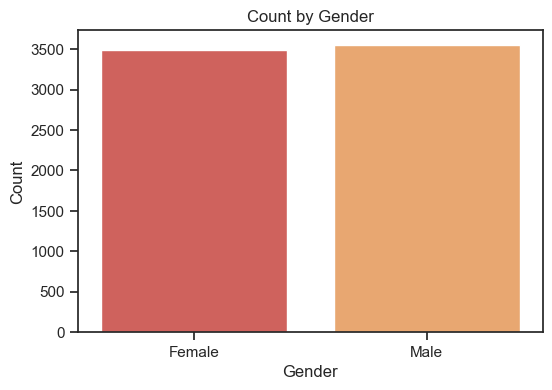

In [404]:
# 단순 개수
# eda_count_categorical(df, 'gender')
plt.figure(figsize=(6, 4))

sns.countplot(data=df, x='gender')
plt.title('Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

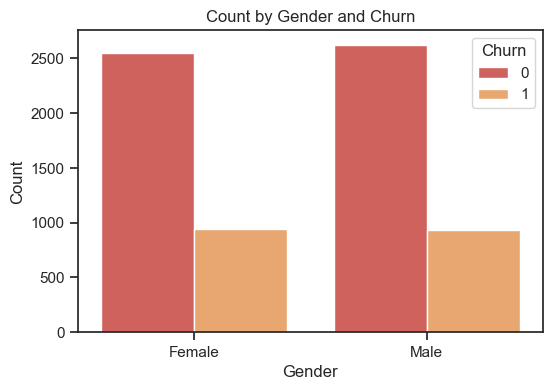

In [405]:
# 단순 개수 + hue로 구분
# eda_count_categorical_target(df, 'gender', 'Churn')
plt.figure(figsize=(6, 4))

sns.countplot(data=df, x='gender', hue='Churn')
plt.title('Count by Gender and Churn')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

   gender  Count  TargetRate  CountPercent  TargetRatePercent
0  Female   3488    0.269209      49.52435          26.920872
1    Male   3555    0.261603      50.47565          26.160338


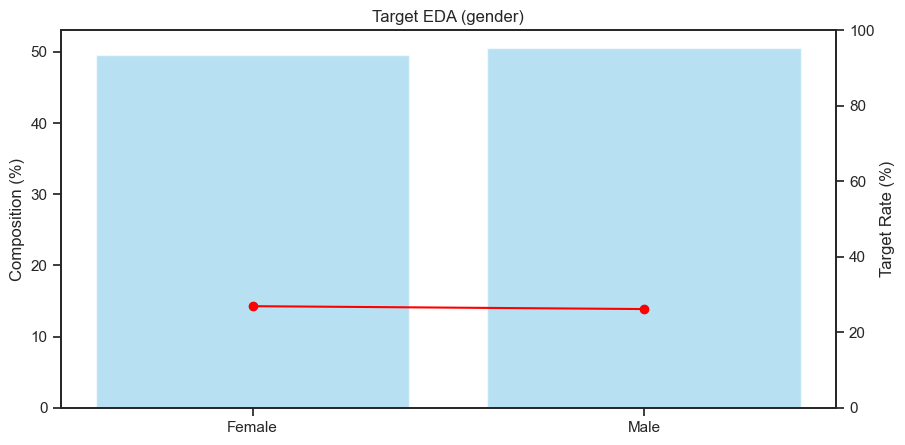

In [406]:
eda_target(df, 'gender', target_col='Churn', bins=10)

## 3.3. Partner에 따른 Churn
- Partner가 없는 사람이 이탈률 32%로 높음

In [407]:
df.groupby('Partner')[['cnt1', 'Churn']].sum()

,cnt1,Churn
Partner,,
No,3641,1200
Yes,3402,669


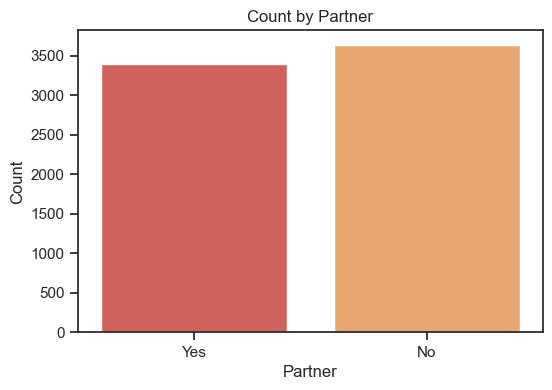

In [408]:
# 단순 개수
eda_count_categorical(df, 'Partner')

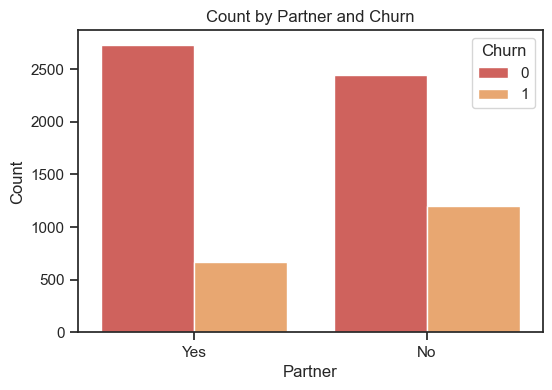

In [409]:
# 단순 개수 + target count(hue)
eda_count_categorical_target(df, 'Partner', 'Churn')

  Partner  Count  TargetRate  CountPercent  TargetRatePercent
0      No   3641    0.329580      51.69672          32.957979
1     Yes   3402    0.196649      48.30328          19.664903


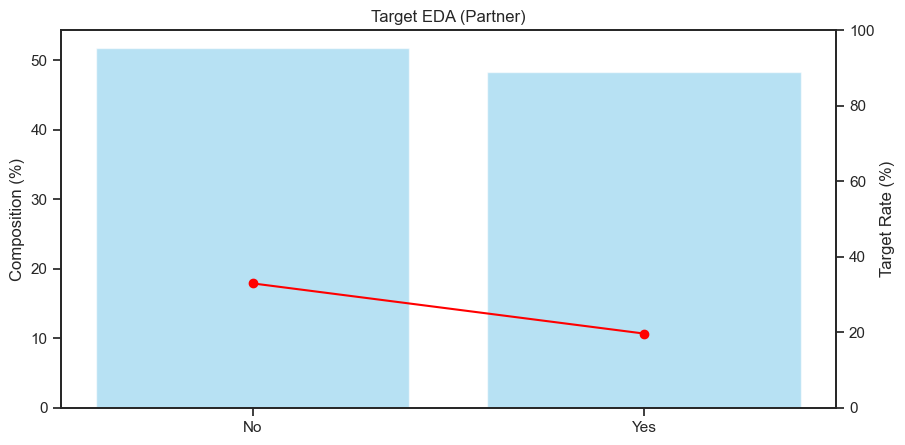

In [410]:
eda_target(df, 'Partner', target_col='Churn', bins=10)

## 3.4. Dependents에 따른 Churn
- 자손 없는 사람이 70%
- 자손 없는 사람의 이탈률 31.3% 수준으로 자손 있는 사람보다 2배 가량 높음

In [411]:
df.groupby('Dependents')[['cnt1', 'Churn']].sum()

,cnt1,Churn
Dependents,,
No,4933,1543
Yes,2110,326


  Dependents  Count  TargetRate  CountPercent  TargetRatePercent
0         No   4933    0.312791     70.041176          31.279140
1        Yes   2110    0.154502     29.958824          15.450237


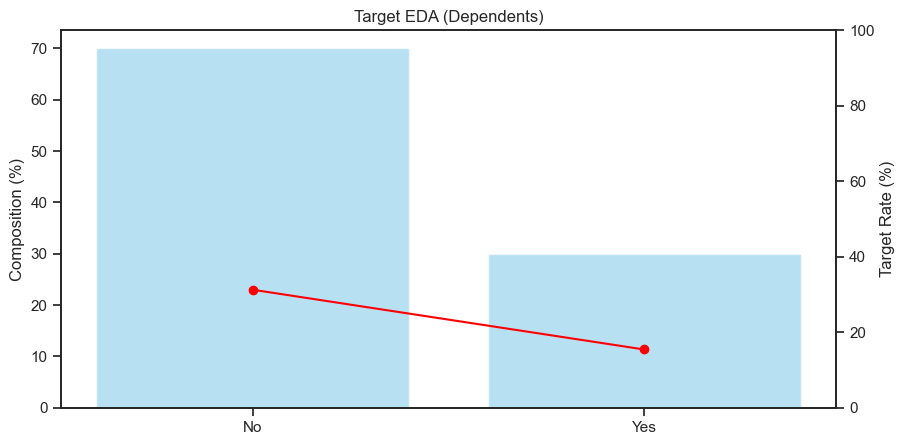

In [412]:
eda_target(df, 'Dependents', target_col='Churn', bins=10)

## 3.5. SeniorCitizen에 따른 Churn
- 시니어는 전체의 16.2%
- 시니어 이탈률 41.7%로 높음

In [413]:
df.groupby('SeniorCitizen')[['cnt1', 'Churn']].sum()

,cnt1,Churn
SeniorCitizen,,
0,5901,1393
1,1142,476


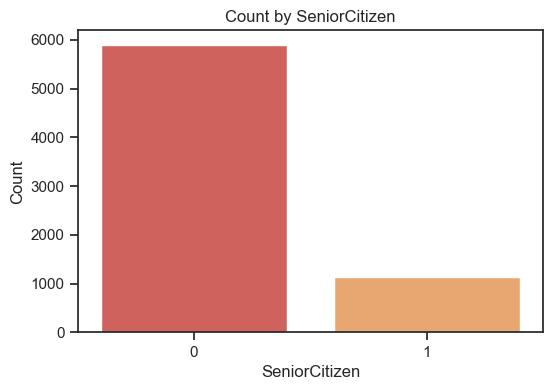

In [414]:
eda_count_categorical(df, 'SeniorCitizen')

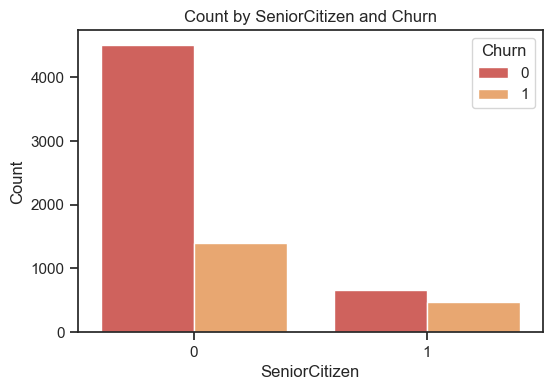

In [415]:
eda_count_categorical_target(df, 'SeniorCitizen', 'Churn')

   SeniorCitizen  Count  TargetRate  CountPercent  TargetRatePercent
0              0   5901    0.236062     83.785319          23.606168
1              1   1142    0.416813     16.214681          41.681261


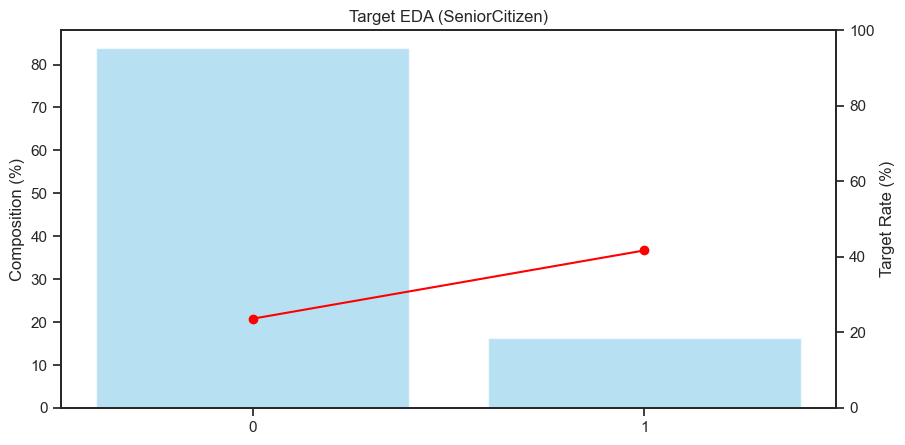

In [416]:
# SeniorCitizen은 int형식이라 is_category=True로 명시해주기!
eda_target(df, 'SeniorCitizen', target_col='Churn', bins=10, is_category=True)

## 3.6. PhoneService에 따른 Churn
- PhoneService 가입자 비중이 전체 중 90%
- PhoneService 가입 유무에 따른 이탈률 차이 없음

In [417]:
df.groupby('PhoneService')[['cnt1', 'Churn']].sum()

,cnt1,Churn
PhoneService,,
No,682,170
Yes,6361,1699


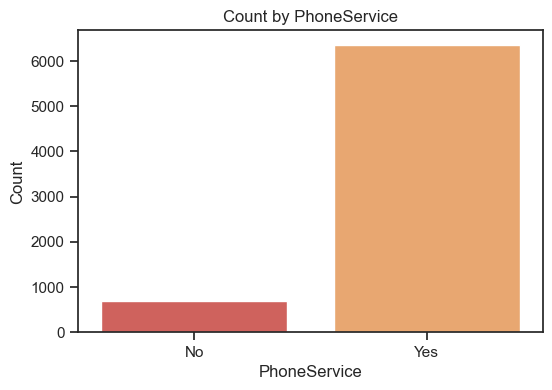

In [418]:
# 단순 개수
eda_count_categorical(df, 'PhoneService')

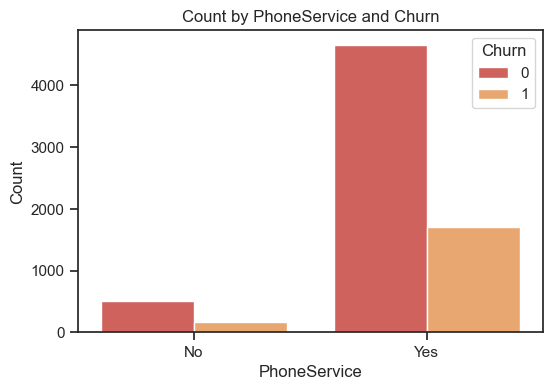

In [419]:
eda_count_categorical_target(df, 'PhoneService', 'Churn')

  PhoneService  Count  TargetRate  CountPercent  TargetRatePercent
0           No    682    0.249267      9.683374          24.926686
1          Yes   6361    0.267096     90.316626          26.709637


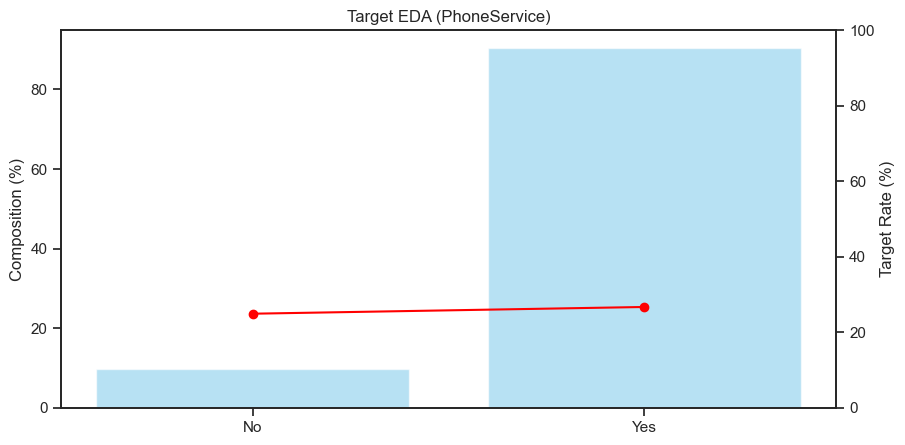

In [420]:
eda_target(df, 'PhoneService', target_col='Churn', bins=10)

## 3.7. MultipleLines에 따른 Churn
- 다중회선 가입자의 이탈률은 28.6%로 단일회선 가입자 대비 이탈률 다소 높음
- 단일회선 가입자 이탈률: 25% 수준

In [421]:
df.groupby('MultipleLines')[['cnt1', 'Churn']].sum()

,cnt1,Churn
MultipleLines,,
No,3390,849
No phone service,682,170
Yes,2971,850


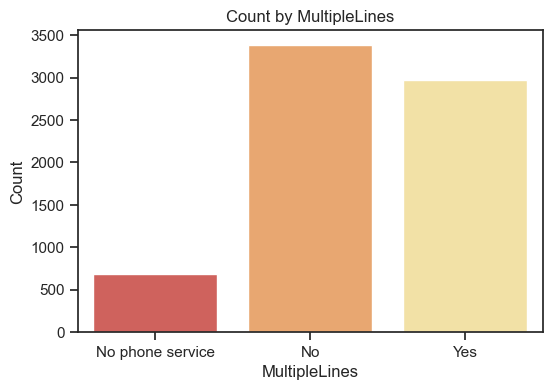

In [422]:
# 단순 개수
eda_count_categorical(df, 'MultipleLines')

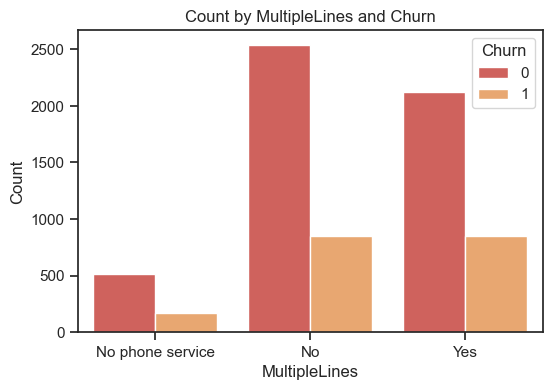

In [423]:
eda_count_categorical_target(df, 'MultipleLines', 'Churn')

      MultipleLines  Count  TargetRate  CountPercent  TargetRatePercent
0                No   3390    0.250442     48.132898          25.044248
1  No phone service    682    0.249267      9.683374          24.926686
2               Yes   2971    0.286099     42.183729          28.609896


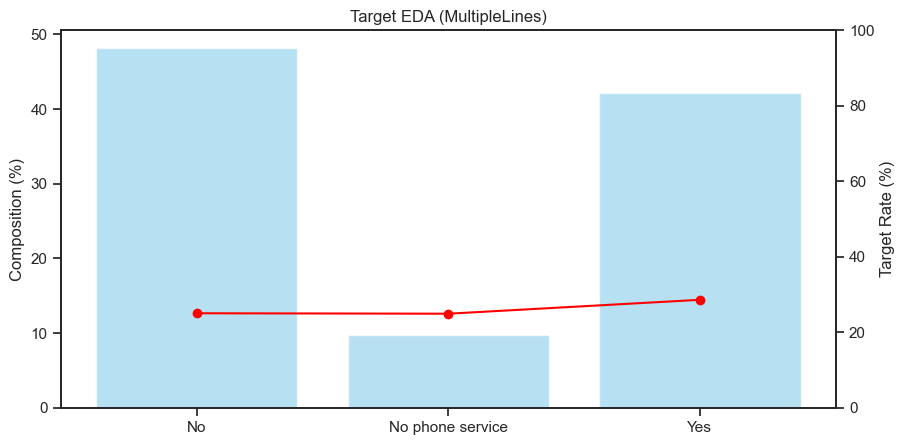

In [424]:
eda_target(df, 'MultipleLines', target_col='Churn', bins=10)

## 3.8. InternetService에 따른 Churn
- Fiber optic은 전체 약 44%비율을 차지하고, 이탈률도 41.9%로 가장 높음

In [425]:
df.groupby('InternetService')[['cnt1', 'Churn']].sum()

,cnt1,Churn
InternetService,,
DSL,2421,459
Fiber optic,3096,1297
No,1526,113


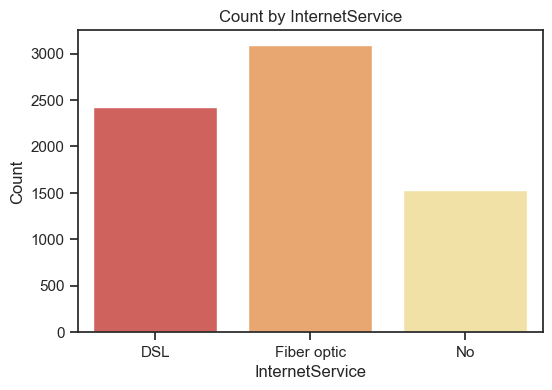

In [426]:
# 단순 개수
eda_count_categorical(df, 'InternetService')

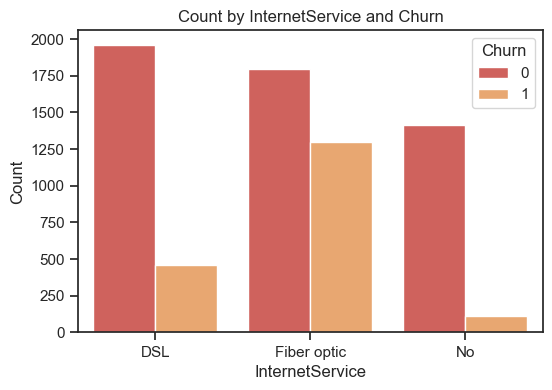

In [427]:
eda_count_categorical_target(df, 'InternetService', 'Churn')

  InternetService  Count  TargetRate  CountPercent  TargetRatePercent
0             DSL   2421    0.189591     34.374556          18.959108
1     Fiber optic   3096    0.418928     43.958540          41.892765
2              No   1526    0.074050     21.666903           7.404980


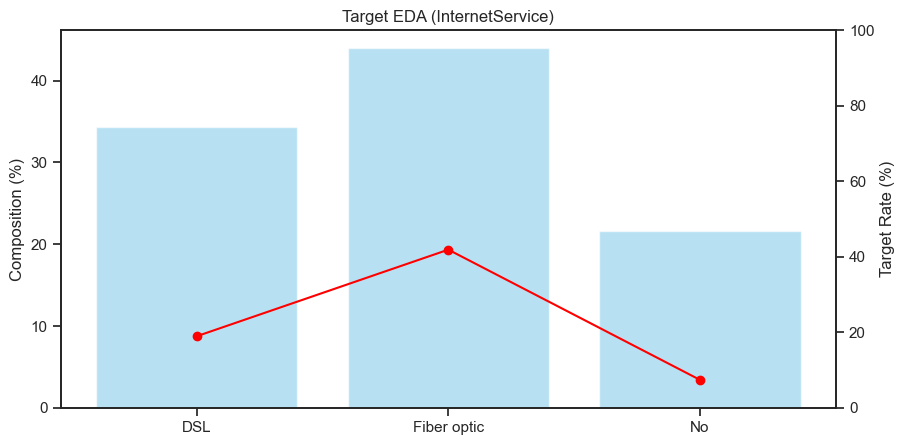

In [428]:
eda_target(df, 'InternetService', target_col='Churn', bins=10)

## 3.9. OnlineSecurity에 따른 Churn
- OnlineSecurity가 'No'인 사람은 전체의 49.7%로 가장 많고, 이탈률도 41.8%로 매우 높음

In [429]:
df.groupby('OnlineSecurity')[['cnt1', 'Churn']].sum()

,cnt1,Churn
OnlineSecurity,,
No,3498,1461
No internet service,1526,113
Yes,2019,295


        OnlineSecurity  Count  TargetRate  CountPercent  TargetRatePercent
0                   No   3498    0.417667     49.666335          41.766724
1  No internet service   1526    0.074050     21.666903           7.404980
2                  Yes   2019    0.146112     28.666761          14.611194


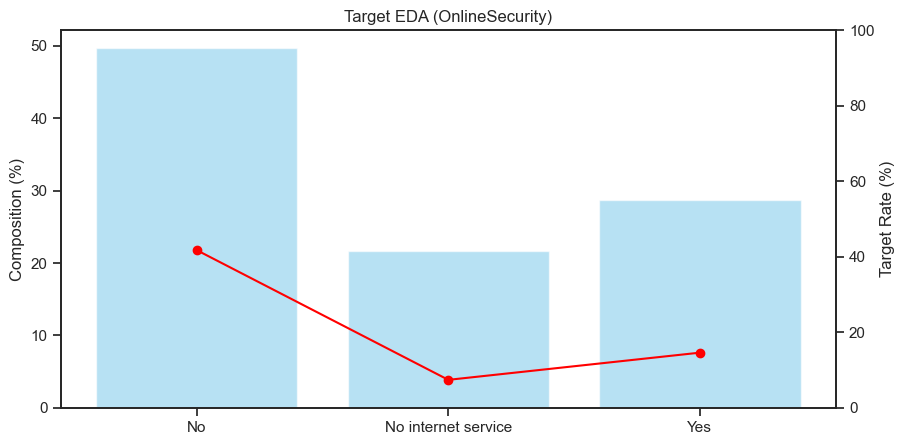

In [430]:
eda_target(df, 'OnlineSecurity', target_col='Churn', bins=10)

## 3.10. OnlineBackup에 따른 Churn
- OnlineBackup이 'No'인 사람은 전체의 43.8%로 가장 많고, 이탈률도 39.9%로 가장 높음
- OnlineBackup이 'Yes'인 사람은 전체의 34.5% 수준

In [431]:
df.groupby('OnlineBackup')[['cnt1', 'Churn']].sum()

,cnt1,Churn
OnlineBackup,,
No,3088,1233
No internet service,1526,113
Yes,2429,523


          OnlineBackup  Count  TargetRate  CountPercent  TargetRatePercent
0                   No   3088    0.399288     43.844952          39.928756
1  No internet service   1526    0.074050     21.666903           7.404980
2                  Yes   2429    0.215315     34.488144          21.531494


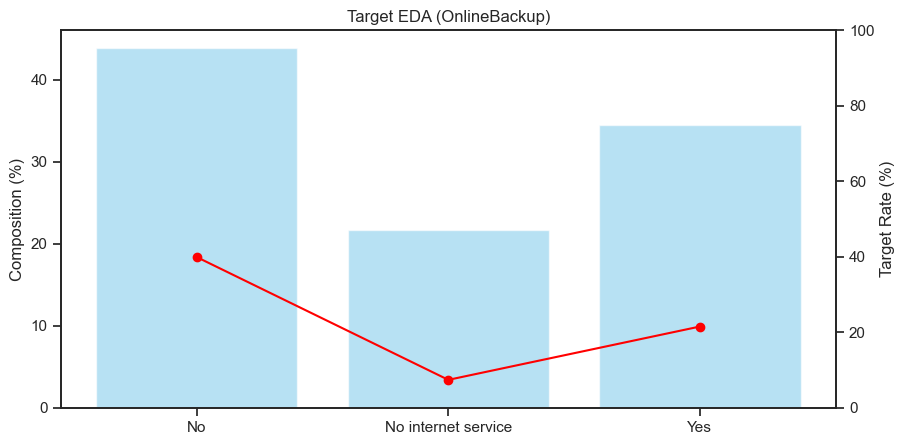

In [432]:
eda_target(df, 'OnlineBackup',  target_col='Churn', bins=10)

## 3.11. DeviceProtection에 따른 Churn
- DeviceProtection이 'No'인 사람은 전체의 43.9%로 가장 많고, 이탈률은 39%로 가장 높음
- DeviceProtection이 'Yes'인 사람의 이탈률은 22.5% 수준

In [433]:
df.groupby('DeviceProtection')[['cnt1', 'Churn']].sum()

,cnt1,Churn
DeviceProtection,,
No,3095,1211
No internet service,1526,113
Yes,2422,545


      DeviceProtection  Count  TargetRate  CountPercent  TargetRatePercent
0                   No   3095    0.391276     43.944342          39.127625
1  No internet service   1526    0.074050     21.666903           7.404980
2                  Yes   2422    0.225021     34.388755          22.502064


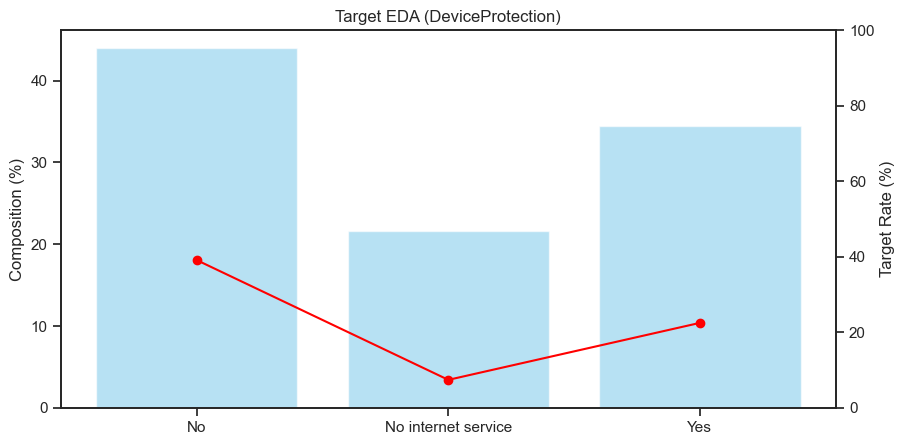

In [434]:
eda_target(df, 'DeviceProtection', target_col='Churn', bins=10)

## 3.12. TechSupport에 따른 Churn
- TechSupport가 'No'인 사람은 전체의 49.3%로 가장 많고, 이탈률은 41.6%로 가장 높음
- TechSupport가 'Yes'인 사람의 이탈률은 15% 수준

In [435]:
df.groupby('TechSupport')[['cnt1', 'Churn']].sum()

,cnt1,Churn
TechSupport,,
No,3473,1446
No internet service,1526,113
Yes,2044,310


           TechSupport  Count  TargetRate  CountPercent  TargetRatePercent
0                   No   3473    0.416355     49.311373          41.635474
1  No internet service   1526    0.074050     21.666903           7.404980
2                  Yes   2044    0.151663     29.021724          15.166341


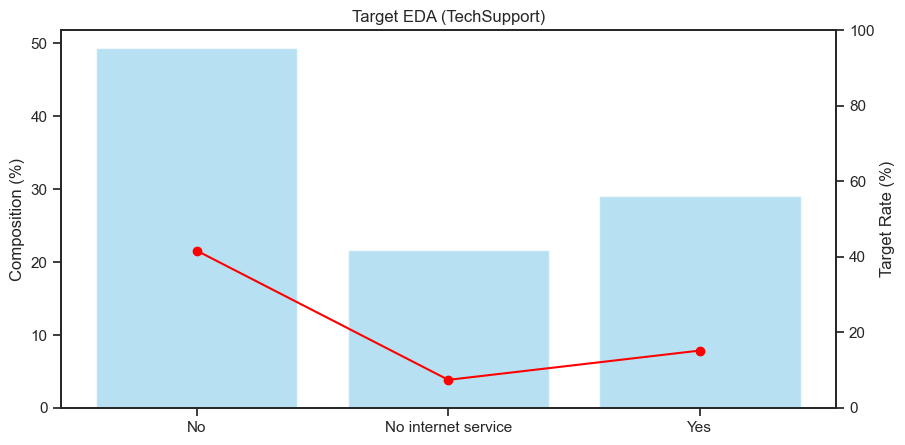

In [436]:
eda_target(df, 'TechSupport', target_col='Churn', bins=10)

## 3.13. StreamingTV에 따른 Churn
- 스트리밍TV를 이용하지 않는 고객의 이탈률이 33.5% 수준으로, 스트리밍TV 이용 고객 대비 3%p 정도 높음

In [437]:
df.groupby('StreamingTV')[['cnt1', 'Churn']].sum()

,cnt1,Churn
StreamingTV,,
No,2810,942
No internet service,1526,113
Yes,2707,814


           StreamingTV  Count  TargetRate  CountPercent  TargetRatePercent
0                   No   2810    0.335231     39.897771          33.523132
1  No internet service   1526    0.074050     21.666903           7.404980
2                  Yes   2707    0.300702     38.435326          30.070188


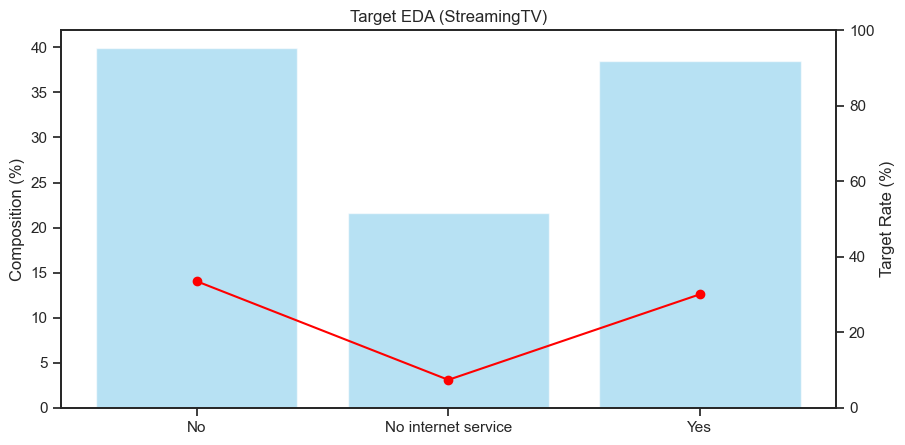

In [438]:
eda_target(df, 'StreamingTV', target_col='Churn', bins=10)

## 3.14. StreamingMovies에 따른 Churn
- 스트리밍 영화를 이용하지 않는 고객의 이탈률은 33.6% 수준으로, 스트리밍 영화 이용 고객 대비 3%p 정도 높음

In [439]:
df.groupby('StreamingMovies')[['cnt1', 'Churn']].sum()

,cnt1,Churn
StreamingMovies,,
No,2785,938
No internet service,1526,113
Yes,2732,818


       StreamingMovies  Count  TargetRate  CountPercent  TargetRatePercent
0                   No   2785    0.336804     39.542808          33.680431
1  No internet service   1526    0.074050     21.666903           7.404980
2                  Yes   2732    0.299414     38.790288          29.941435


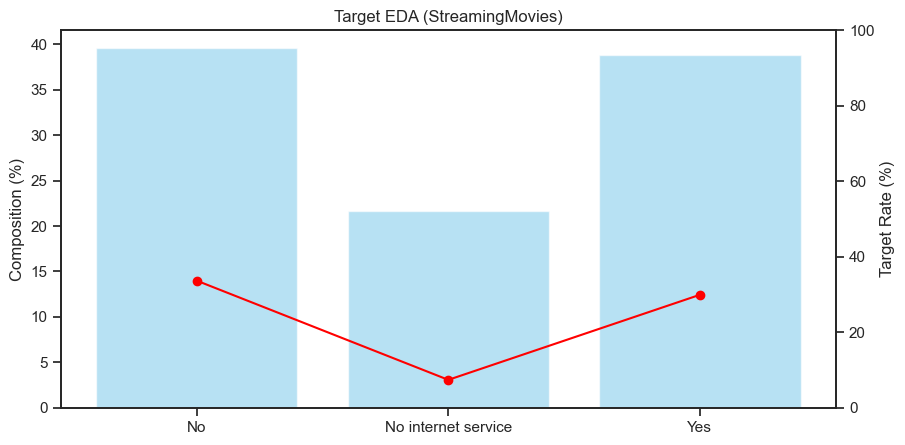

In [440]:
eda_target(df, 'StreamingMovies', target_col='Churn', bins=10)

## 3.15. Contract에 따른 Churn
- 계약기간이 'Month-to-Month'인 고객의 이탈률이 42.7% 수준으로 'One year', 'Two year'보다 매우 높음

In [441]:
df.groupby('Contract')[['cnt1', 'Churn']].sum()

,cnt1,Churn
Contract,,
Month-to-month,3875,1655
One year,1473,166
Two year,1695,48


         Contract  Count  TargetRate  CountPercent  TargetRatePercent
0  Month-to-month   3875    0.427097     55.019168          42.709677
1        One year   1473    0.112695     20.914383          11.269518
2        Two year   1695    0.028319     24.066449           2.831858


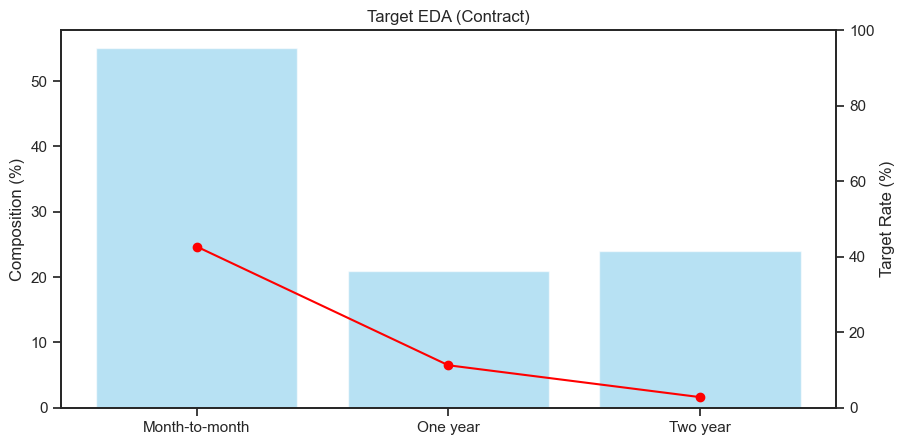

In [442]:
eda_target(df, 'Contract', target_col='Churn', bins=10)

## 3.16. PaperlessBilling에 따른 Churn
- PaperlessBilling이 'Yes'인 고객의 이탈률이 33.6% 수준으로, 'No'인 고객 대비 2배정도 높음

In [443]:
df.groupby('PaperlessBilling')[['cnt1', 'Churn']].sum()

,cnt1,Churn
PaperlessBilling,,
No,2872,469
Yes,4171,1400


  PaperlessBilling  Count  TargetRate  CountPercent  TargetRatePercent
0               No   2872    0.163301     40.778078          16.330084
1              Yes   4171    0.335651     59.221922          33.565092


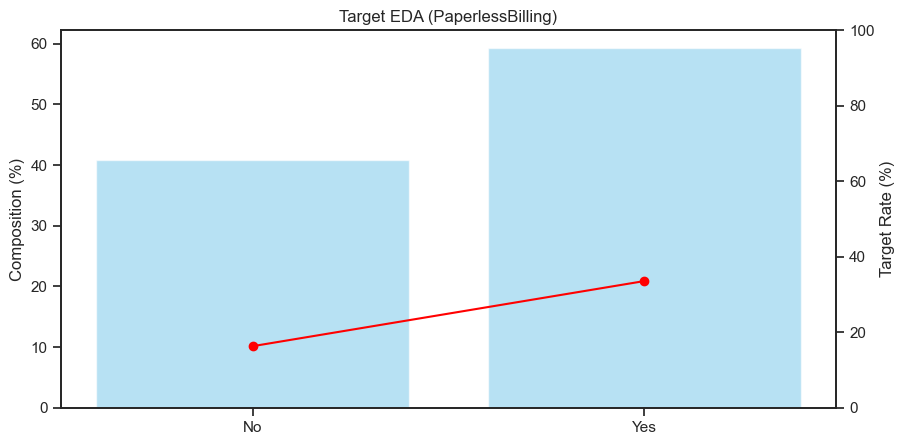

In [444]:
eda_target(df, 'PaperlessBilling', target_col='Churn', bins=10)

## 3.17. PaymentMethod에 따른 Churn
- 지불방식이 'Electronic check'인 고객의 이탈률이 45.3% 수준으로 매우 높음

In [445]:
df.groupby('PaymentMethod')[['cnt1', 'Churn']].sum()

,cnt1,Churn
PaymentMethod,,
Bank transfer (automatic),1544,258
Credit card (automatic),1522,232
Electronic check,2365,1071
Mailed check,1612,308


               PaymentMethod  Count  TargetRate  CountPercent  \
0  Bank transfer (automatic)   1544    0.167098     21.922476   
1    Credit card (automatic)   1522    0.152431     21.610109   
2           Electronic check   2365    0.452854     33.579441   
3               Mailed check   1612    0.191067     22.887974   

   TargetRatePercent  
0          16.709845  
1          15.243101  
2          45.285412  
3          19.106700  


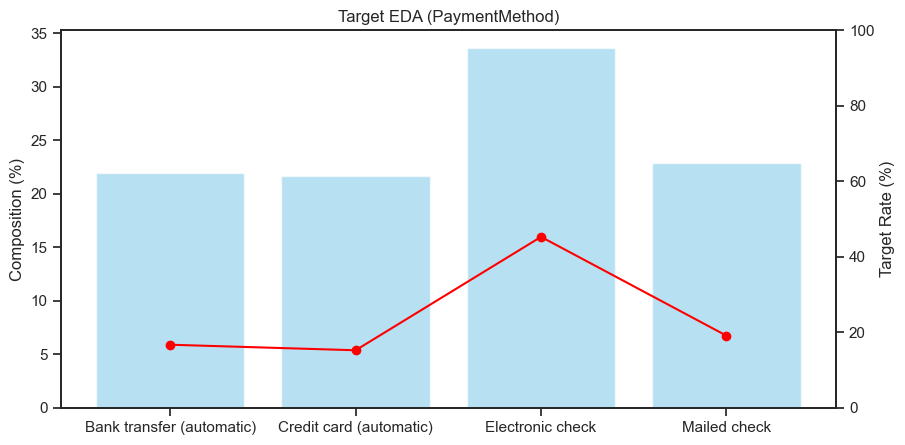

In [446]:
eda_target(df, 'PaymentMethod', target_col='Churn', bins=10)

## ✍️3.18. tenure에 따른 Churn
- tenure가 14 이하인 사람의 이탈률이 30% 이상
- 비율은 누적인가????? 해석 방법 더 찾아보기!

In [447]:
len(df['tenure'].unique())
# 73

73

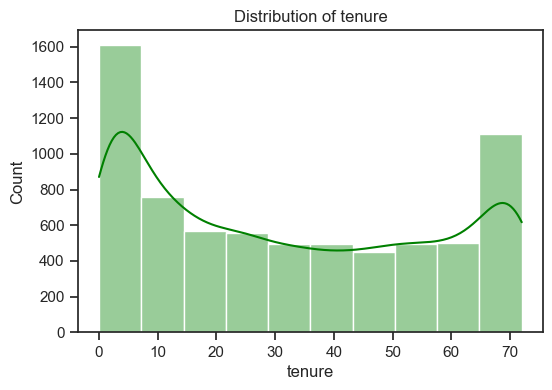

In [448]:
# ✍️수치형 데이터는 먼저 histplot 그려보기!
plt.figure(figsize=(6, 4))

sns.histplot(df['tenure'], bins=10, kde=True, color='green', alpha=0.4)
plt.title('Distribution of tenure')
plt.xlabel('tenure')
plt.ylabel('Count')

plt.show()

  tenure_bin  Count  TargetRate  CountPercent  TargetRatePercent
0     -0.072   1612    0.517990     22.887974          51.799007
1      7.200    759    0.347826     10.776658          34.782609
2     14.400    570    0.296491      8.093142          29.649123
3     21.600    556    0.226619      7.894363          22.661871
4     28.800    545    0.214679      7.738180          21.467890
5     36.000    444    0.220721      6.304132          22.072072
6     43.200    452    0.159292      6.417720          15.929204
7     50.400    495    0.141414      7.028255          14.141414
8     57.600    501    0.091816      7.113446           9.181637
9     64.800   1109    0.064923     15.746131           6.492335


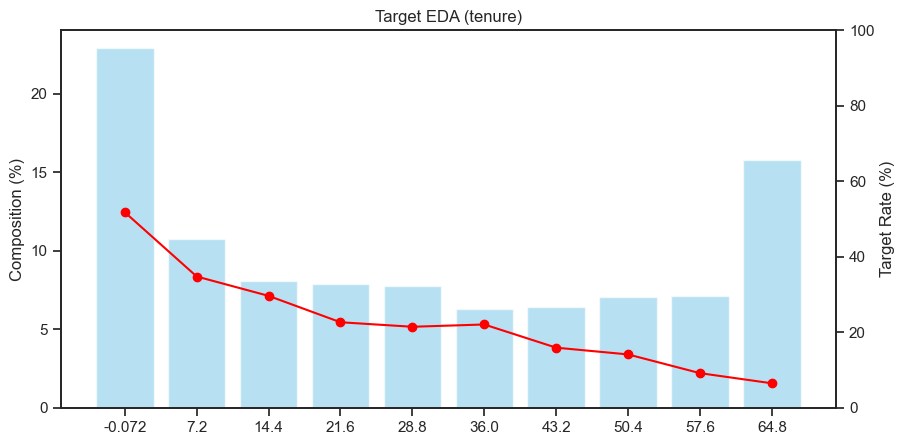

In [449]:
# uniform(균등) binning
eda_target(df, 'tenure', target_col='Churn', method='uniform', bins=10)

  tenure_bin  Count  TargetRate  CountPercent  TargetRatePercent
0     -0.001    862    0.583527     12.239103          58.352668
1      2.000    619    0.453958      8.788868          45.395800
2      6.000    705    0.358865     10.009939          35.886525
3     12.000    692    0.309249      9.825359          30.924855
4     20.000    691    0.228654      9.811160          22.865412
5     29.000    717    0.218968     10.180321          21.896792
6     40.000    652    0.176380      9.257419          17.638037
7     50.000    698    0.136103      9.910549          13.610315
8     60.000    756    0.092593     10.734062           9.259259
9     69.000    651    0.035330      9.243220           3.533026


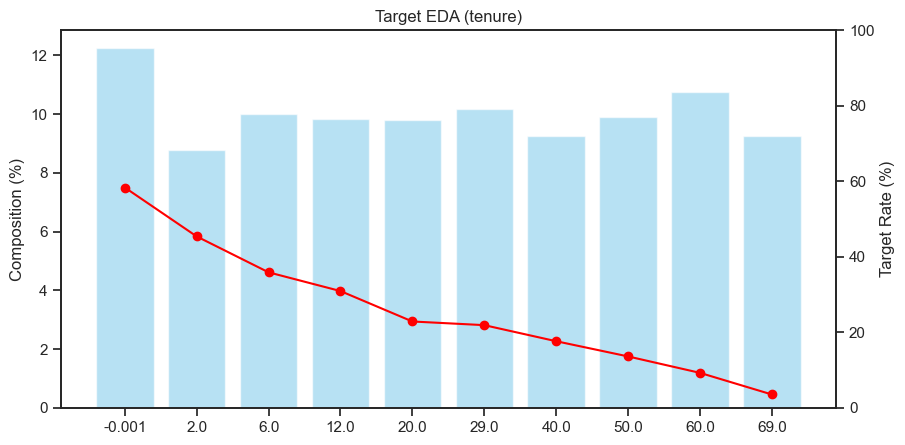

In [450]:
# quantile(분위수) binning
eda_target(df, 'tenure', target_col='Churn', method='quantile', bins=10)

## 3.19. MonthlyCharges에 따른 Churn
- 월 청구액 70~100달러 구간에서 이탈률 36~39% 수준으로 매우 높음

In [451]:
len(df['MonthlyCharges'].unique())
# 1585

1585

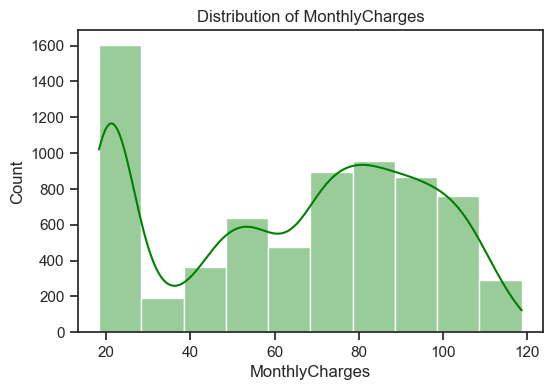

In [452]:
plt.figure(figsize=(6, 4))

sns.histplot(df['MonthlyCharges'], bins=10, kde=True, color='green', alpha=.4)
plt.title('Distribution of MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Count')

plt.show()

  MonthlyCharges_bin  Count  TargetRate  CountPercent  TargetRatePercent
0              18.15   1606    0.092154     22.802783           9.215442
1              28.30    191    0.298429      2.711913          29.842932
2              38.35    365    0.326027      5.182451          32.602740
3              48.40    640    0.237500      9.087037          23.750000
4              58.45    474    0.113924      6.730087          11.392405
5              68.50    893    0.390817     12.679256          39.081747
6              78.55    953    0.372508     13.531166          37.250787
7              88.60    873    0.366552     12.395286          36.655212
8              98.65    754    0.360743     10.705665          36.074271
9             108.70    294    0.146259      4.174358          14.625850


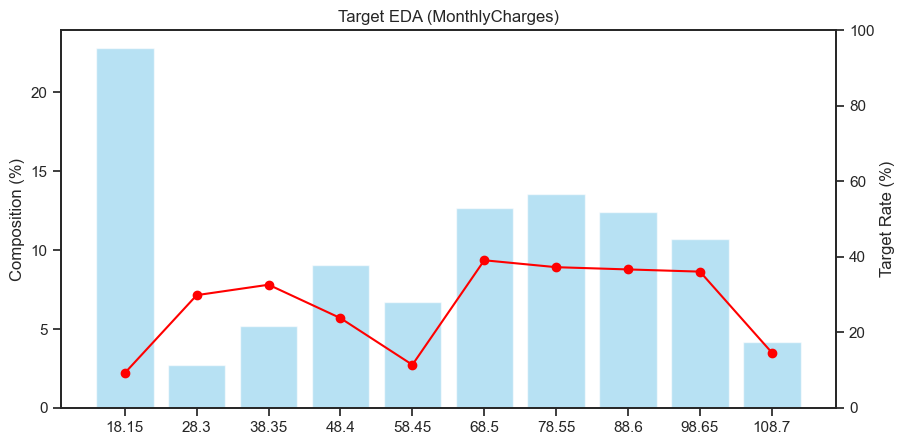

In [453]:
# uniform(균등) binning
# 이게 quantile보다 더 보편적으로 많이 쓰임
eda_target(df, 'MonthlyCharges', target_col='Churn', method='uniform', bins=10)

  MonthlyCharges_bin  Count  TargetRate  CountPercent  TargetRatePercent
0             18.249    717    0.085077     10.180321           8.507671
1             20.050    703    0.098151      9.981542           9.815078
2             25.050    695    0.254676      9.867954          25.467626
3             45.850    702    0.245014      9.967343          24.501425
4             58.830    711    0.215190     10.095130          21.518987
5             70.350    700    0.381429      9.938946          38.142857
6             79.100    705    0.378723     10.009939          37.872340
7             85.500    702    0.343305      9.967343          34.330484
8             94.250    704    0.409091      9.995740          40.909091
9            102.600    704    0.247159      9.995740          24.715909


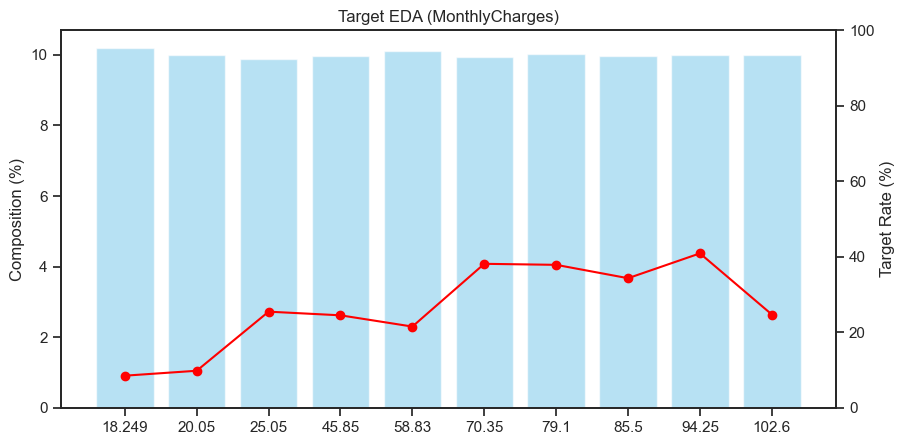

In [454]:
# quantile(분위수) binning
eda_target(df, 'MonthlyCharges', target_col='Churn', bins=10)

## 3.20. TotalCharges에 따른 Churn
- 총 청구액 10~885달러 구간에서 이탈률 37% 수준으로 매우 높음

In [455]:
len(df['TotalCharges'].unique())
# 6531

6531

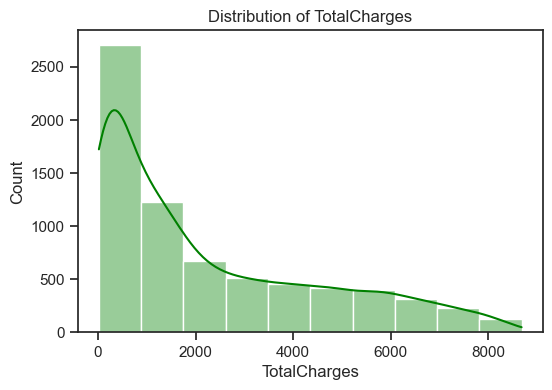

In [456]:
plt.figure(figsize=(6,4))

sns.histplot(df['TotalCharges'], bins=10, kde=True, color='green', alpha=.4)
plt.title('Distribution of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Count')

plt.show()

  TotalCharges_bin  Count  TargetRate  CountPercent  TargetRatePercent
0           10.134   2709    0.377999     38.523891          37.799926
1          885.400   1228    0.220684     17.463026          22.068404
2         1752.000    671    0.247392      9.542093          24.739195
3         2618.600    508    0.246063      7.224118          24.606299
4         3485.200    454    0.160793      6.456200          16.079295
5         4351.800    412    0.167476      5.858931          16.747573
6         5218.400    395    0.146835      5.617179          14.683544
7         6085.000    310    0.148387      4.408419          14.838710
8         6951.600    223    0.143498      3.171217          14.349776
9         7818.200    122    0.040984      1.734926           4.098361


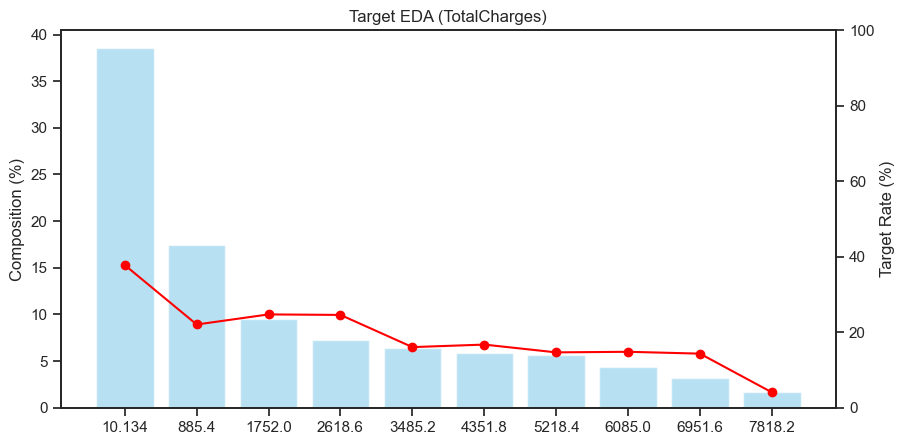

In [457]:
# uniform(균등) binning
eda_target(df, 'TotalCharges', target_col='Churn', method='uniform', bins=10)

# 4. 데이터 전처리

## 4.1. 결측치 처리
- `1012회의` 데이터가 크면 isna 오래걸려서 그냥 함수 만들어서 na본다고 함

### 4.1.1. 해당 데이터에서 사용한 방식(결측치 데이터 제거)

In [458]:
# 결측치 확인
df.isna().sum()
# TotalCharges에 결측치 11개 존재

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
cnt1                 0
dtype: int64

In [459]:
# 결측치 데이터 확인
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cnt1
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,1
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0,1
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0,1
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0,1
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0,1
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0,1
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0,1
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0,1
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0,1
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0,1


In [460]:
# 전체 데이터 중 일부이므로 삭제
df = df.dropna(subset='TotalCharges')

# ✍️평균값 대체도 가능
# df = df.fillna(df["TotalCharges"].mean())

In [461]:
df.isna().sum()
# 0

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
cnt1                0
dtype: int64

### 4.1.2. (Option) 결측치 행 삭제
- 이 데이터에서는 4.1에서 진행 완료

In [261]:
df2 = df.copy()  # copy 해야 값복사

In [262]:
df2.shape

(7032, 22)

In [263]:
df2['temp'] = df2['TotalCharges'].tolist()

In [82]:
df2[df2['temp'].isnull() == True].shape

(0, 23)

In [83]:
# 결측치가 있는 행 삭제
df2.dropna(subset=['temp'], inplace=True)

### 4.1.3. (Option) 결측치 컬럼 삭제
- 이 데이터에서는 진행 X

In [84]:
df3 = df.copy()  # copy 해야 값복사

In [85]:
df3['temp'] = np.where(np.random.rand(len(df)) < 0.2, np.nan, np.random.randint(50, 200, size=7043))

ValueError: operands could not be broadcast together with shapes (7032,) () (7043,) 

In [ ]:
df3[df3['temp'].isnull() == True].shape

(1427, 23)

In [ ]:
# 결측치가 있는 컬럼 삭제
df3.drop(columns=['temp'], inplace=True)

In [ ]:
df3.shape

(7043, 22)

### 4.1.4. (Option) 결측치 자체가 의미 있을 때 다른 값으로 치환
- 이 데이터에서는 진행 X

In [ ]:
df4 = df.copy()  # copy 해야 값복사

In [ ]:
df4['temp'] = np.where(np.random.rand(len(df)) < 0.2, np.nan, np.random.randint(50, 200, size=7043))

In [ ]:
df4[df4['temp'].isnull() == True].shape

(1483, 23)

In [ ]:
# 결측치 다른 값으로 치환
df4['temp'].fillna(-999, inplace=True)

In [ ]:
df4[df4['temp'].isnull() == True].shape

(0, 23)

### 4.1.5. (Option) 결측치를 평균값으로 대체
- 이 데이터에서는 진행 X

In [ ]:
df5 = df.copy()  # copy 해야 값복사

In [ ]:
df5['temp'] = np.where(np.random.rand(len(df)) < 0.2, np.nan, np.random.randint(50, 200, size=7043))

In [ ]:
df5[df5['temp'].isnull() == True].shape

(1425, 23)

In [ ]:
# 결측치 다른 값으로 치환
df5['temp'].fillna(df5['temp'].mean(), inplace=True)

In [ ]:
df5[df5['temp'].isnull() == True].shape

(0, 23)

### 4.1.6. (Option) 결측치를 중앙값으로 대체 (이상치가 많을 경우)
- 이 데이터에서는 진행 X

In [ ]:
df6 = df.copy()  # copy 해야 값복사

In [ ]:
df6['temp'] = np.where(np.random.rand(len(df)) < 0.2, np.nan, np.random.randint(50, 200, size=7043))

In [ ]:
df6[df6['temp'].isnull() == True].shape

(1371, 23)

In [ ]:
# 결측치 다른 값으로 치환
df6['temp'].fillna(df6['temp'].median(), inplace=True)

In [ ]:
df6[df6['temp'].isnull() == True].shape

(0, 23)

### 4.1.7. (Option) 결측치를 이전 행의 값으로 대체 (센서 데이터의 경우)
- 이 데이터에서는 진행 X

In [ ]:
df7 = df.copy()  # copy 해야 값복사

In [ ]:
df7['temp'] = np.where(np.random.rand(len(df)) < 0.2, np.nan, np.random.randint(50, 200, size=7043))

In [ ]:
df7[df7['temp'].isnull() == True].shape

(1420, 23)

In [ ]:
df7['temp'].head()

0      NaN
1    188.0
2    163.0
3    193.0
4    131.0
Name: temp, dtype: float64

In [ ]:
df7['temp'].tail()

7038    142.0
7039      NaN
7040     77.0
7041    120.0
7042     85.0
Name: temp, dtype: float64

In [ ]:
df7['temp'] = df7['temp'].fillna(method='ffill')

In [ ]:
df7['temp'].head()

0      NaN
1    188.0
2    163.0
3    193.0
4    131.0
Name: temp, dtype: float64

In [ ]:
df7['temp'].tail()

7038    142.0
7039    142.0
7040     77.0
7041    120.0
7042     85.0
Name: temp, dtype: float64

### 4.1.8. (Option) 결측치를 이후 행의 값으로 대체 (센서 데이터의 경우)
- 이 데이터에서는 진행 X

In [ ]:
df8 = df.copy()  # copy 해야 값복사

In [ ]:
df8['temp'] = np.where(np.random.rand(len(df)) < 0.2, np.nan, np.random.randint(50, 200, size=7043))

In [ ]:
df8[df8['temp'].isnull() == True].shape

(1381, 23)

In [ ]:
df8['temp'].head()

0    122.0
1    126.0
2    158.0
3    146.0
4    152.0
Name: temp, dtype: float64

In [ ]:
df8['temp'].tail()

7038      NaN
7039    100.0
7040    121.0
7041     93.0
7042    111.0
Name: temp, dtype: float64

In [ ]:
df8['temp'] = df8['temp'].fillna(method='bfill')

In [ ]:
df8['temp'].head()

0    122.0
1    126.0
2    158.0
3    146.0
4    152.0
Name: temp, dtype: float64

In [ ]:
df8['temp'].tail()

7038    100.0
7039    100.0
7040    121.0
7041     93.0
7042    111.0
Name: temp, dtype: float64

### 4.1.9. (Option) imputation 모델 이용해 결측치 처리
- 이 데이터에서는 진행 X

In [ ]:
df9 = df.copy()  # copy 해야 값복사

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df9_imputed = imputer.fit_transform(df9[['TotalCharges', 'MonthlyCharges', 'tenure', 'Churn']])

In [ ]:
df9_imputed = pd.DataFrame(df9_imputed, columns=['TotalCharges', 'MonthlyCharges', 'tenure', 'Churn'])

In [ ]:
df9_imputed.head()

,TotalCharges,MonthlyCharges,tenure,Churn
0,29.85,29.85,1.0,0.0
1,1889.50,56.95,34.0,0.0
2,108.15,53.85,2.0,1.0
3,1840.75,42.30,45.0,0.0
4,151.65,70.70,2.0,1.0


In [ ]:
df9['TotalCharges'] = list(df9['TotalCharges'])

In [ ]:
df9.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cnt1
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1


## 4.2. 이상치 처리
- IQR 이상치 제거 기준에 걸리는 값은 없음

In [462]:
num_x = df.loc[:, ['tenure', 'MonthlyCharges', 'TotalCharges']]
num_x.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


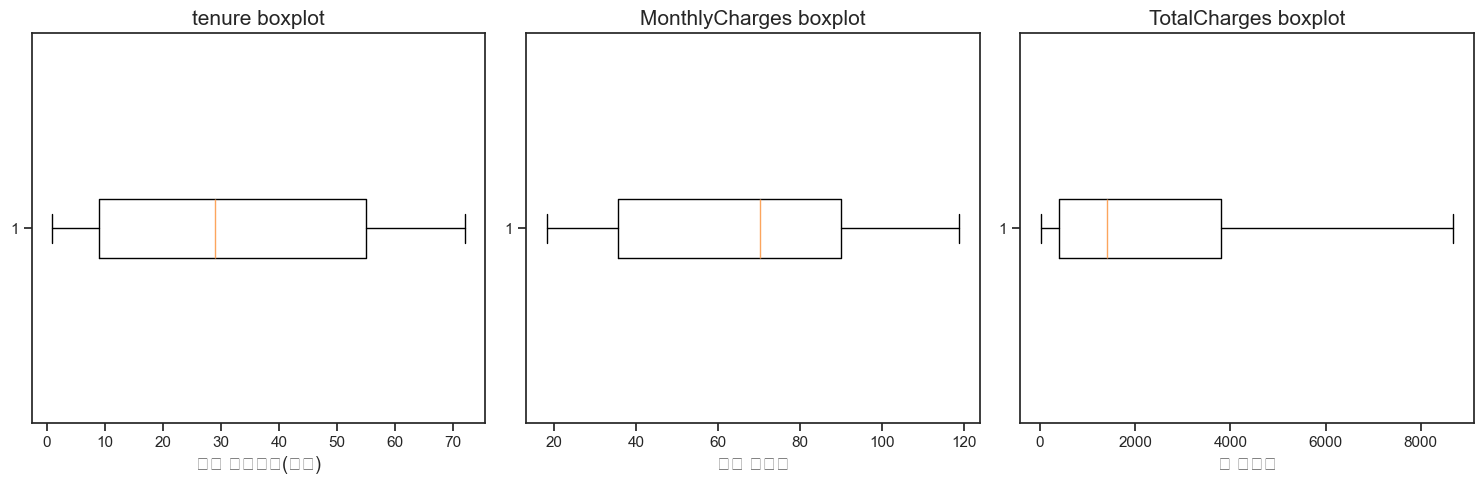

In [463]:
# 이상치 확인(boxplot)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
box_txt = ['고객 체류기간(개월)', '매월 청구액', '총 청구액']  # 후에 딕셔너리로 바꿔서 영<->한 만들어놔도 좋을듯

for i in range(len(num_x.columns)):
    ax[i].boxplot(num_x.iloc[:, i], vert=False)
    ax[i].set_title(f'{num_x.columns[i]} boxplot', size=15)
    ax[i].set_xlabel(box_txt[i], size=13)

plt.tight_layout()
plt.show()

# ✍️5. 문자형 데이터 처리 및 스케일링

1. 문자형 데이터
- 라벨 인코딩
    - 트리계열 모델(DT, RF)에서 주로 사용
    - 트리계열 모델은 수치의 특성을 반영하지 않기 때문
- 원핫 인코딩
    - 선형 모델(LR, SVM 등)에서 사용
    - 선형 모델의 경우 수치가 가중치에 영향을 주기 때문

2. 수치형 데이터
- Min-Max Scailing
- StandardScaler
    - 이상치에 민감하므로 이상치가 많지 않은 데이터에 사용
    - 데이터가 정규분포에 가까울수록 좋음
    - 대부분 ML모델에 적합

## ✍️5.1. 문자형 데이터 더미화

In [464]:
# cnt1열 삭제(불필요)
df = df.drop(columns=['cnt1'])

# 뒤에서 트리계열 모델을 사용할 예정이므로, 먼저 라벨 인코딩 진행
le = LabelEncoder()
cat_list = df.select_dtypes(include=['object']).columns

for cat in cat_list:
    df[cat] = le.fit_transform(df[cat])

# 더미화 진행하려면 아래처럼!
#df_dummies = pd.get_dummies(df)
#df_dummies.head()

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   int32  
 1   gender            7032 non-null   int32  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   int32  
 4   Dependents        7032 non-null   int32  
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   int32  
 7   MultipleLines     7032 non-null   int32  
 8   InternetService   7032 non-null   int32  
 9   OnlineSecurity    7032 non-null   int32  
 10  OnlineBackup      7032 non-null   int32  
 11  DeviceProtection  7032 non-null   int32  
 12  TechSupport       7032 non-null   int32  
 13  StreamingTV       7032 non-null   int32  
 14  StreamingMovies   7032 non-null   int32  
 15  Contract          7032 non-null   int32  
 16  PaperlessBilling  7032 non-null   int32  


In [466]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## ✍️5.2. 연속형 데이터 Scale

In [467]:
scaler = StandardScaler()
numc_list = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[numc_list] = scaler.fit_transform(df[numc_list])

In [468]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,4843,1,0,1,1,-0.343137,1,2,0,2,...,2,2,2,2,1,1,3,0.664868,-0.129180,0
7039,1524,0,0,1,1,1.612573,1,2,1,0,...,2,0,2,2,1,1,1,1.276493,2.241056,0
7040,3358,0,0,1,1,-0.872808,0,1,0,2,...,0,0,0,0,0,1,2,-1.170004,-0.854514,0
7041,5923,1,1,1,0,-1.158016,1,2,1,0,...,0,0,0,0,0,1,3,0.319168,-0.872095,1
7042,2221,1,0,0,0,1.368109,1,0,1,2,...,2,2,2,2,2,1,0,1.357932,2.012344,0


In [469]:
# 위에서 더미화 이후 멘토님 코드 참고
#y = df_dummies['Churn'].values
#X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
#from sklearn.preprocessing import MinMaxScaler
#features = X.columns.values
#scaler = MinMaxScaler(feature_range = (0,1))
#scaler.fit(X)
#X = pd.DataFrame(scaler.transform(X))
#X.columns = features

#X.head()

In [470]:
#y

# 6. Baseline Model 학습 및 성능 비교

## 6.1. 변수 설정

In [471]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [506]:
X = df.iloc[:, :20]
y = df['Churn']

In [508]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1018)

In [509]:
X_train.shape

(5625, 20)

## 6.2. Random Forest (전체 변수 사용)

In [521]:
# 모델 및 평가
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=2025)
model.fit(X_train.iloc[:, 1:],y_train)
predictions = model.predict(X_valid.iloc[:, 1:])

print(f'학습 데이터 성능: {model.score(X_train.iloc[:, 1:], y_train):.3f}')
 
output = pd.DataFrame({'customerID': X_valid.customerID, 'Churn': predictions})
print(output.head())

# .csv 저장
#output.to_csv('output.csv', index=False)

# 성능평가
print(f'검증 데이터 성능: {model.score(X_valid.iloc[:, 1:], y_valid):.3f}')

학습 데이터 성능: 0.825
      customerID  Churn
1881        3144      0
5970        3415      1
3362        2553      0
1057        1111      0
36          4282      1
검증 데이터 성능: 0.812


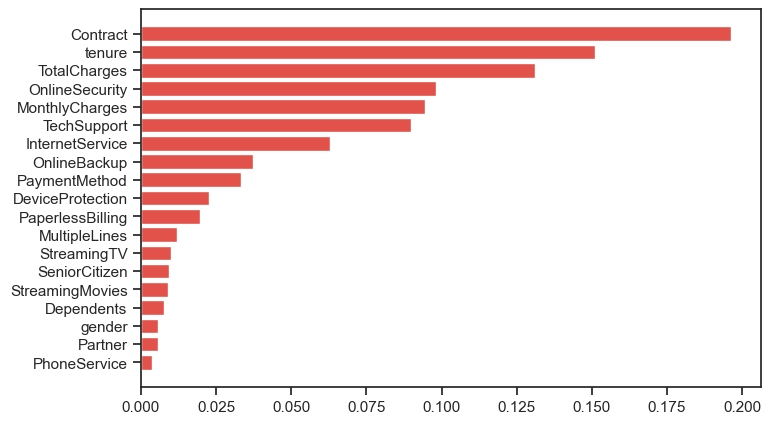

In [511]:
# 변수 중요도
#print(model.feature_importances_)

# 변수 중요도 시각화
importances = model.feature_importances_
feature_names = X_train.iloc[:, 1:].columns

# to DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importances': importances
}).sort_values(by='Importances', ascending=False)

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importances'])
plt.gca().invert_yaxis()  # 중요도 높은게 위로 오도록

plt.show()

## 6.3. Random Forest (일부 변수 사용)
- EDA결과 종속변수(y)와 연관이 있었던 변수만 사용
- 아주 미세하게 개선(0.812 -> `0.817`)

In [ ]:
eda_result_col = ['Partner', 'Dependents', 'SeniorCitizen', 'MultipleLines', 'InternetService',
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
                  'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [520]:
# 모델 및 평가
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=2025)
model2.fit(X_train[eda_result_col].iloc[:, 1:], y_train)
predictions2 = model2.predict(X_valid[eda_result_col].iloc[:, 1:])

print(f'학습 데이터 성능: {model2.score(X_train[eda_result_col].iloc[:, 1:], y_train):.3f}')
 
output2 = pd.DataFrame({'customerID': X_valid.customerID, 'Churn': predictions2})
print(output2.head())

# .csv 저장
#output2.to_csv('output2.csv', index=False)

# 성능평가
print(f'검증 데이터 성능: {model2.score(X_valid[eda_result_col].iloc[:, 1:], y_valid):.3f}')

학습 데이터 성능: 0.820
      customerID  Churn
1881        3144      0
5970        3415      1
3362        2553      0
1057        1111      0
36          4282      1
검증 데이터 성능: 0.817


## 6.4. LightGBM
- XGB보다 학습 속도가 빠르면서 정확성이 높음
- 정확도 `0.800`

In [523]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [530]:
# 모델 학습
lgbm = LGBMClassifier(random_state=2025)
lgbm.fit(X_train.iloc[:, 1:], y_train)

# predict
predictions3 = lgbm.predict(X_valid.iloc[:, 1:])
accuracy = accuracy_score(y_valid, predictions3)

print(f'정확도: {accuracy:.3f}')

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
정확도: 0.800


## 6.5. LightGBM(optuna를 통한 파라미터 튜닝)

In [532]:
import optuna
from lightgbm import callback
from lightgbm.callback import early_stopping, log_evaluation  # 콜백 함수 가져오기

In [538]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'force_row_wise': True,  # 행 단위 작업 강제 설정
        'n_jobs': -1,  # 모든 CPU 코어 사용
        'random_state': 2025  # 재현 가능성 확보를 위한 랜덤 시드 설정
    }

    # 모델 학습
    model = LGBMClassifier(**param)
    model.fit(X_train.iloc[:, 1:], y_train, eval_set=[(X_valid.iloc[:, 1:], y_valid)],
          eval_metric='binary_error', callbacks=[early_stopping(stopping_rounds=10), log_evaluation(period=1)])

    # predict
    preds = model.predict(X_valid.iloc[:, 1:])
    accuracy = accuracy_score(y_valid, preds)

    return accuracy

In [539]:
# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적 하이퍼파라미터 출력
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: ", study.best_value)

# 최적 하이퍼파라미터 모델 학습 및 예측
best_params = study.best_params
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train.iloc[:, 1:], y_train)

# 예측 및 평가
preds = best_model.predict(X_valid.iloc[:, 1:])
accuracy = accuracy_score(y_valid, preds)
print(f"Test accuracy: {accuracy:.4f}")

[I 2025-10-18 23:06:53,956] A new study created in memory with name: no-name-56c6e614-5960-4439-8793-cb7e6252d536
[I 2025-10-18 23:06:54,012] Trial 0 finished with value: 0.736318407960199 and parameters: {'num_leaves': 50, 'learning_rate': 0.0027748442171347315, 'n_estimators': 291, 'max_depth': 17, 'min_child_samples': 92, 'subsample': 0.5133169724567008, 'colsample_bytree': 0.8217737726648395}. Best is trial 0 with value: 0.736318407960199.
[I 2025-10-18 23:06:54,038] Trial 1 finished with value: 0.736318407960199 and parameters: {'num_leaves': 113, 'learning_rate': 0.007826519764383354, 'n_estimators': 276, 'max_depth': 22, 'min_child_samples': 88, 'subsample': 0.7060815637570692, 'colsample_bytree': 0.8159936831913784}. Best is trial 0 with value: 0.736318407960199.
[I 2025-10-18 23:06:54,077] Trial 2 finished with value: 0.736318407960199 and parameters: {'num_leaves': 149, 'learning_rate': 0.008876302634098096, 'n_estimators': 71, 'max_depth': 12, 'min_child_samples': 65, 'subsa

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576025
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.575148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.574293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.573441
[LightGBM] [Warning] No

[I 2025-10-18 23:06:54,174] Trial 5 finished with value: 0.736318407960199 and parameters: {'num_leaves': 23, 'learning_rate': 0.003748220427079116, 'n_estimators': 60, 'max_depth': 12, 'min_child_samples': 80, 'subsample': 0.7201825680788128, 'colsample_bytree': 0.5943655696739922}. Best is trial 0 with value: 0.736318407960199.
[I 2025-10-18 23:06:54,219] Trial 6 finished with value: 0.736318407960199 and parameters: {'num_leaves': 44, 'learning_rate': 0.00017403191786309052, 'n_estimators': 255, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.9887567953053272, 'colsample_bytree': 0.8158952912167754}. Best is trial 0 with value: 0.736318407960199.
[I 2025-10-18 23:06:54,252] Trial 7 finished with value: 0.736318407960199 and parameters: {'num_leaves': 126, 'learning_rate': 0.010922911532597364, 'n_estimators': 153, 'max_depth': 20, 'min_child_samples': 94, 'subsample': 0.5121721010034448, 'colsample_bytree': 0.6832105332677032}. Best is trial 0 with value: 0.736318407960199.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576835
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576779
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576724
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576669
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576614
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576557
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576502
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576446
[9]	valid_0's binary_error: 0.26368

[I 2025-10-18 23:06:54,525] Trial 11 finished with value: 0.8130774697938877 and parameters: {'num_leaves': 82, 'learning_rate': 0.043943400960589914, 'n_estimators': 233, 'max_depth': 29, 'min_child_samples': 42, 'subsample': 0.7851294919795351, 'colsample_bytree': 0.9849666836084652}. Best is trial 10 with value: 0.8130774697938877.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.562818
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.550086
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.538794
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.528581
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.51913
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.510893
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.503312
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.496091
[9]	valid_0's binary_error: 0.263682

[I 2025-10-18 23:06:54,701] Trial 12 finished with value: 0.8130774697938877 and parameters: {'num_leaves': 90, 'learning_rate': 0.08640996063414018, 'n_estimators': 227, 'max_depth': 30, 'min_child_samples': 37, 'subsample': 0.7854572958067012, 'colsample_bytree': 0.9778118137817897}. Best is trial 10 with value: 0.8130774697938877.


[15]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.425576
[16]	valid_0's binary_error: 0.189765	valid_0's binary_logloss: 0.423237
[17]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.421039
[18]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.419408
[19]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.418008
[20]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.416722
[21]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.415839
[22]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.414632
[23]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.414125
[24]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.41391
[25]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.413365
[26]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.413807
[27]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.413479
[28]	valid_0's binary_error: 0.190476	valid_0's bina

[I 2025-10-18 23:06:54,786] Trial 13 finished with value: 0.814498933901919 and parameters: {'num_leaves': 83, 'learning_rate': 0.09695993740766214, 'n_estimators': 222, 'max_depth': 30, 'min_child_samples': 44, 'subsample': 0.8033974347356059, 'colsample_bytree': 0.9677170304565924}. Best is trial 13 with value: 0.814498933901919.
[I 2025-10-18 23:06:54,843] Trial 14 finished with value: 0.736318407960199 and parameters: {'num_leaves': 89, 'learning_rate': 0.036065522132477455, 'n_estimators': 207, 'max_depth': 26, 'min_child_samples': 27, 'subsample': 0.8261521201219534, 'colsample_bytree': 0.5005727806207483}. Best is trial 13 with value: 0.814498933901919.
[I 2025-10-18 23:06:54,906] Trial 15 finished with value: 0.736318407960199 and parameters: {'num_leaves': 74, 'learning_rate': 0.0008798122968412547, 'n_estimators': 249, 'max_depth': 26, 'min_child_samples': 50, 'subsample': 0.644674923081554, 'colsample_bytree': 0.9088965417142605}. Best is trial 13 with value: 0.8144989339019

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.565183
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.557514
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.547515
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.538457
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.532716
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.524737
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.517457
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.510263
[9]	valid_0's binary_error: 0.26368

[I 2025-10-18 23:06:55,024] Trial 17 finished with value: 0.814498933901919 and parameters: {'num_leaves': 102, 'learning_rate': 0.07324359303464498, 'n_estimators': 208, 'max_depth': 24, 'min_child_samples': 50, 'subsample': 0.9201057736797011, 'colsample_bytree': 0.9947370619718633}. Best is trial 13 with value: 0.814498933901919.
[I 2025-10-18 23:06:55,080] Trial 18 finished with value: 0.736318407960199 and parameters: {'num_leaves': 103, 'learning_rate': 0.021367846220925198, 'n_estimators': 126, 'max_depth': 22, 'min_child_samples': 73, 'subsample': 0.9431606482165201, 'colsample_bytree': 0.9185602437111888}. Best is trial 13 with value: 0.814498933901919.
[I 2025-10-18 23:06:55,127] Trial 19 finished with value: 0.736318407960199 and parameters: {'num_leaves': 106, 'learning_rate': 0.0008547173755925334, 'n_estimators': 207, 'max_depth': 24, 'min_child_samples': 50, 'subsample': 0.889832027871017, 'colsample_bytree': 0.9995361209344829}. Best is trial 13 with value: 0.8144989339

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.570116
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.563557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.55744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.551568
[LightGBM] [Warning] No 

[I 2025-10-18 23:06:55,249] Trial 20 finished with value: 0.736318407960199 and parameters: {'num_leaves': 102, 'learning_rate': 0.016917235990135556, 'n_estimators': 263, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.990765052083054, 'colsample_bytree': 0.8688758959232894}. Best is trial 13 with value: 0.814498933901919.
[I 2025-10-18 23:06:55,328] Trial 21 finished with value: 0.8194740582800284 and parameters: {'num_leaves': 62, 'learning_rate': 0.09990862291027247, 'n_estimators': 215, 'max_depth': 28, 'min_child_samples': 45, 'subsample': 0.8242283850158166, 'colsample_bytree': 0.9544681095583708}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:55,403] Trial 22 finished with value: 0.8173418621179815 and parameters: {'num_leaves': 62, 'learning_rate': 0.09102216051009761, 'n_estimators': 203, 'max_depth': 27, 'min_child_samples': 51, 'subsample': 0.8751712704249864, 'colsample_bytree': 0.9393700305270817}. Best is trial 21 with value: 0.81947405828

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.545983
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.52185
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.502606
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.487212
[5]	valid_0's binary_error: 0.235963	valid_0's binary_logloss: 0.474171
[6]	valid_0's binary_error: 0.224591	valid_0's binary_logloss: 0.462803
[7]	valid_0's binary_error: 0.204691	valid_0's binary_logloss: 0.453342
[8]	valid_0's binary_error: 0.19403	valid_0's binary_logloss: 0.446024
[9]	valid_0's binary_error: 0.191187	

[I 2025-10-18 23:06:55,493] Trial 23 finished with value: 0.8187633262260128 and parameters: {'num_leaves': 61, 'learning_rate': 0.047475266076753064, 'n_estimators': 189, 'max_depth': 27, 'min_child_samples': 56, 'subsample': 0.8292238797365256, 'colsample_bytree': 0.943467245130443}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:55,581] Trial 24 finished with value: 0.8187633262260128 and parameters: {'num_leaves': 34, 'learning_rate': 0.044261392156134914, 'n_estimators': 183, 'max_depth': 27, 'min_child_samples': 72, 'subsample': 0.8470161604789381, 'colsample_bytree': 0.9388127507831149}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:55,629] Trial 25 finished with value: 0.736318407960199 and parameters: {'num_leaves': 33, 'learning_rate': 0.041791719601067645, 'n_estimators': 175, 'max_depth': 22, 'min_child_samples': 73, 'subsample': 0.7451492247111584, 'colsample_bytree': 0.8639482130175877}. Best is trial 21 with value: 0.819474058

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.563106
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.550489
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.539331
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.529454
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.520499
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.512051
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.504139
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.496929
[9]	valid_0's binary_error: 0.26368

[I 2025-10-18 23:06:55,730] Trial 27 finished with value: 0.736318407960199 and parameters: {'num_leaves': 21, 'learning_rate': 0.015294582495350621, 'n_estimators': 100, 'max_depth': 24, 'min_child_samples': 80, 'subsample': 0.8373441189168666, 'colsample_bytree': 0.8621237786720372}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:55,795] Trial 28 finished with value: 0.736318407960199 and parameters: {'num_leaves': 58, 'learning_rate': 0.0018677050619620667, 'n_estimators': 180, 'max_depth': 19, 'min_child_samples': 57, 'subsample': 0.7484339703133409, 'colsample_bytree': 0.7614635131377123}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:55,884] Trial 29 finished with value: 0.8123667377398721 and parameters: {'num_leaves': 51, 'learning_rate': 0.05361235948833917, 'n_estimators': 299, 'max_depth': 15, 'min_child_samples': 85, 'subsample': 0.5555947079838788, 'colsample_bytree': 0.7716365096714177}. Best is trial 21 with value: 0.819474058

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576287
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.575787
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.575184
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.574597
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.574015
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.573425
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.572825
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.572237
[9]	valid_0's binary_error: 0.26368

[I 2025-10-18 23:06:56,016] Trial 31 finished with value: 0.8123667377398721 and parameters: {'num_leaves': 65, 'learning_rate': 0.053159272126148446, 'n_estimators': 199, 'max_depth': 27, 'min_child_samples': 54, 'subsample': 0.8645159931294145, 'colsample_bytree': 0.9528206663575628}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,130] Trial 32 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 62, 'learning_rate': 0.09881496788838225, 'n_estimators': 160, 'max_depth': 21, 'min_child_samples': 65, 'subsample': 0.9590811813314635, 'colsample_bytree': 0.8815329493055988}. Best is trial 21 with value: 0.8194740582800284.


[18]	valid_0's binary_error: 0.191898	valid_0's binary_logloss: 0.439368
[19]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.436626
[20]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.434038
[21]	valid_0's binary_error: 0.189765	valid_0's binary_logloss: 0.431493
[22]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.429408
[23]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.427376
[24]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.425559
[25]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.423601
[26]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.421911
[27]	valid_0's binary_error: 0.189765	valid_0's binary_logloss: 0.420373
[28]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.418973
[29]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.417496
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.436626
[LightGBM] [Info

[I 2025-10-18 23:06:56,240] Trial 33 finished with value: 0.8173418621179815 and parameters: {'num_leaves': 30, 'learning_rate': 0.05954495415430319, 'n_estimators': 242, 'max_depth': 28, 'min_child_samples': 99, 'subsample': 0.8687364933066699, 'colsample_bytree': 0.9385180895767478}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,308] Trial 34 finished with value: 0.736318407960199 and parameters: {'num_leaves': 73, 'learning_rate': 0.029973708933306677, 'n_estimators': 173, 'max_depth': 23, 'min_child_samples': 44, 'subsample': 0.8253256569781121, 'colsample_bytree': 0.8519578400437771}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,366] Trial 35 finished with value: 0.736318407960199 and parameters: {'num_leaves': 48, 'learning_rate': 0.013816858680191918, 'n_estimators': 138, 'max_depth': 26, 'min_child_samples': 67, 'subsample': 0.672589533056215, 'colsample_bytree': 0.906375779975396}. Best is trial 21 with value: 0.819474058280

[21]	valid_0's binary_error: 0.19403	valid_0's binary_logloss: 0.427038
[22]	valid_0's binary_error: 0.191898	valid_0's binary_logloss: 0.424677
[23]	valid_0's binary_error: 0.192608	valid_0's binary_logloss: 0.422937
[24]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.421189
[25]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.419335
[26]	valid_0's binary_error: 0.183369	valid_0's binary_logloss: 0.418065
[27]	valid_0's binary_error: 0.182658	valid_0's binary_logloss: 0.4168
[28]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.415693
[29]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.414626
[30]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.413628
[31]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.412573
[32]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.411887
[33]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.410747
[34]	valid_0's binary_error: 0.187633	valid_0's binary_l

[I 2025-10-18 23:06:56,482] Trial 36 finished with value: 0.8173418621179815 and parameters: {'num_leaves': 72, 'learning_rate': 0.06138527206481994, 'n_estimators': 217, 'max_depth': 25, 'min_child_samples': 32, 'subsample': 0.9114352915274434, 'colsample_bytree': 0.8397592986292873}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,544] Trial 37 finished with value: 0.736318407960199 and parameters: {'num_leaves': 57, 'learning_rate': 0.007498575729841393, 'n_estimators': 270, 'max_depth': 16, 'min_child_samples': 52, 'subsample': 0.708251571567351, 'colsample_bytree': 0.7816423681487045}. Best is trial 21 with value: 0.8194740582800284.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.557635
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.540976
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.526697
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.513956
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.502343
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.492794
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.484333
[8]	valid_0's binary_error: 0.241649	valid_0's binary_logloss: 0.476787
[9]	valid_0's binary_error: 0.22530

[I 2025-10-18 23:06:56,589] Trial 38 finished with value: 0.736318407960199 and parameters: {'num_leaves': 30, 'learning_rate': 0.0024243750628864086, 'n_estimators': 195, 'max_depth': 28, 'min_child_samples': 75, 'subsample': 0.9553702221546169, 'colsample_bytree': 0.8910917673633209}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,663] Trial 39 finished with value: 0.736318407960199 and parameters: {'num_leaves': 50, 'learning_rate': 0.0003369390583408503, 'n_estimators': 282, 'max_depth': 20, 'min_child_samples': 60, 'subsample': 0.7646081704549006, 'colsample_bytree': 0.715764670946686}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,718] Trial 40 finished with value: 0.736318407960199 and parameters: {'num_leaves': 45, 'learning_rate': 0.031157909803863255, 'n_estimators': 158, 'max_depth': 29, 'min_child_samples': 46, 'subsample': 0.8584322166287894, 'colsample_bytree': 0.9561227689400729}. Best is trial 21 with value: 0.819474058

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576782
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576691
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576582
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576476
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.57637
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576262
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576152
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.576044
[9]	valid_0's binary_error: 0.263682

[I 2025-10-18 23:06:56,812] Trial 41 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 26, 'learning_rate': 0.057679980793635795, 'n_estimators': 242, 'max_depth': 27, 'min_child_samples': 90, 'subsample': 0.8821405267519301, 'colsample_bytree': 0.937213878063286}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,916] Trial 42 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 36, 'learning_rate': 0.06510431961193956, 'n_estimators': 237, 'max_depth': 29, 'min_child_samples': 99, 'subsample': 0.8620745747506884, 'colsample_bytree': 0.9228293984771994}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:56,967] Trial 43 finished with value: 0.736318407960199 and parameters: {'num_leaves': 29, 'learning_rate': 0.02071550828501583, 'n_estimators': 181, 'max_depth': 25, 'min_child_samples': 100, 'subsample': 0.8068533343548603, 'colsample_bytree': 0.9600919168610376}. Best is trial 21 with value: 0.8194740582

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.557163
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.540142
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.525708
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.513302
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.50182
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.491824
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.482666
[8]	valid_0's binary_error: 0.233831	valid_0's binary_logloss: 0.474821
[9]	valid_0's binary_error: 0.228145

[I 2025-10-18 23:06:57,109] Trial 45 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 61, 'learning_rate': 0.09993795585191828, 'n_estimators': 256, 'max_depth': 5, 'min_child_samples': 96, 'subsample': 0.8312025828806592, 'colsample_bytree': 0.8907693277643292}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:57,167] Trial 46 finished with value: 0.736318407960199 and parameters: {'num_leaves': 20, 'learning_rate': 0.04534976864792474, 'n_estimators': 188, 'max_depth': 26, 'min_child_samples': 41, 'subsample': 0.8127006499171209, 'colsample_bytree': 0.7972427952703803}. Best is trial 21 with value: 0.8194740582800284.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.548633
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.52581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.50722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.492279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_error: 0.254442	valid_0's binary_logloss: 0.480155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_error: 0.234542	valid_0's binary_logloss: 0.469337
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-10-18 23:06:57,247] Trial 47 finished with value: 0.814498933901919 and parameters: {'num_leaves': 52, 'learning_rate': 0.07183131175072636, 'n_estimators': 227, 'max_depth': 30, 'min_child_samples': 18, 'subsample': 0.7335332409413939, 'colsample_bytree': 0.9716598939507608}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:57,393] Trial 48 finished with value: 0.736318407960199 and parameters: {'num_leaves': 76, 'learning_rate': 0.03259732581084717, 'n_estimators': 200, 'max_depth': 23, 'min_child_samples': 79, 'subsample': 0.8489872393681209, 'colsample_bytree': 0.9365442597652663}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:57,437] Trial 49 finished with value: 0.736318407960199 and parameters: {'num_leaves': 67, 'learning_rate': 0.0051731927497063335, 'n_estimators': 166, 'max_depth': 27, 'min_child_samples': 32, 'subsample': 0.7938015200628675, 'colsample_bytree': 0.8310295575074328}. Best is trial 21 with value: 0.81947405828

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.566683
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.557142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.548376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.540342
[LightGBM] [Warning] No

[I 2025-10-18 23:06:57,575] Trial 51 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 116, 'learning_rate': 0.0735344497339273, 'n_estimators': 245, 'max_depth': 29, 'min_child_samples': 64, 'subsample': 0.9421018094738843, 'colsample_bytree': 0.9711446900487299}. Best is trial 21 with value: 0.8194740582800284.
[I 2025-10-18 23:06:57,670] Trial 52 finished with value: 0.8123667377398721 and parameters: {'num_leaves': 93, 'learning_rate': 0.051866929613754394, 'n_estimators': 235, 'max_depth': 28, 'min_child_samples': 46, 'subsample': 0.9747120780317552, 'colsample_bytree': 0.9994632690147445}. Best is trial 21 with value: 0.8194740582800284.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.421704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.41955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.417627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's binary_error: 0.183369	valid_0's binary_logloss: 0.416135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.415117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's binary_error: 0.183369	valid_0's binary_logloss: 0.41394
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.183369	valid_0's binary_logloss: 0.435357
[LightGBM]

[I 2025-10-18 23:06:57,754] Trial 53 finished with value: 0.820184790334044 and parameters: {'num_leaves': 96, 'learning_rate': 0.07662125484402688, 'n_estimators': 217, 'max_depth': 30, 'min_child_samples': 56, 'subsample': 0.9255800738875561, 'colsample_bytree': 0.9150974032605167}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:57,886] Trial 54 finished with value: 0.8180525941719972 and parameters: {'num_leaves': 96, 'learning_rate': 0.08326727874131423, 'n_estimators': 212, 'max_depth': 30, 'min_child_samples': 55, 'subsample': 0.9244394326466515, 'colsample_bytree': 0.9144051023092753}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.55125
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.52998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.512871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.498253
[LightGBM] [Warning] No f

[I 2025-10-18 23:06:57,997] Trial 55 finished with value: 0.820184790334044 and parameters: {'num_leaves': 96, 'learning_rate': 0.040023132781322385, 'n_estimators': 214, 'max_depth': 30, 'min_child_samples': 61, 'subsample': 0.9302308171506508, 'colsample_bytree': 0.9168487369093872}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:58,088] Trial 56 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 110, 'learning_rate': 0.041356335709984794, 'n_estimators': 223, 'max_depth': 30, 'min_child_samples': 71, 'subsample': 0.9007075215368637, 'colsample_bytree': 0.8819695915632327}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:58,141] Trial 57 finished with value: 0.736318407960199 and parameters: {'num_leaves': 79, 'learning_rate': 0.026264577754150194, 'n_estimators': 255, 'max_depth': 12, 'min_child_samples': 62, 'subsample': 0.9713867120214851, 'colsample_bytree': 0.5397349273293883}. Best is trial 53 with value: 0.8201847903

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.563933
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.55197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.541366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.531717
[LightGBM] [Warning] No 

[I 2025-10-18 23:06:58,290] Trial 59 finished with value: 0.8152096659559346 and parameters: {'num_leaves': 97, 'learning_rate': 0.039806803017236984, 'n_estimators': 182, 'max_depth': 26, 'min_child_samples': 67, 'subsample': 0.9042466112109234, 'colsample_bytree': 0.9034682725438823}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:58,384] Trial 60 finished with value: 0.8173418621179815 and parameters: {'num_leaves': 98, 'learning_rate': 0.07239210741442961, 'n_estimators': 233, 'max_depth': 29, 'min_child_samples': 56, 'subsample': 0.9840779241635917, 'colsample_bytree': 0.9242241351677286}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's binary_error: 0.209666	valid_0's binary_logloss: 0.452257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_error: 0.207534	valid_0's binary_logloss: 0.449481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's binary_error: 0.206823	valid_0's binary_logloss: 0.44668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's binary_error: 0.203269	valid_0's binary_logloss: 0.444257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's binary_error: 0.194741	valid_0's binary_logloss: 0.442105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's binary_error: 0.193319	valid_0's binary_logloss: 0.439789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's binary_error: 0.193319	

[I 2025-10-18 23:06:58,497] Trial 61 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 93, 'learning_rate': 0.08217055780050891, 'n_estimators': 208, 'max_depth': 30, 'min_child_samples': 55, 'subsample': 0.9223545868749219, 'colsample_bytree': 0.9195298564156617}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:58,610] Trial 62 finished with value: 0.8137882018479033 and parameters: {'num_leaves': 113, 'learning_rate': 0.04708934256733135, 'n_estimators': 212, 'max_depth': 30, 'min_child_samples': 62, 'subsample': 0.9518032376028009, 'colsample_bytree': 0.9623888356536733}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.424522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.422786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.420374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.418807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.417021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.415867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's binary_error: 0.185501	v

[I 2025-10-18 23:06:58,739] Trial 63 finished with value: 0.8152096659559346 and parameters: {'num_leaves': 88, 'learning_rate': 0.09991764143355499, 'n_estimators': 195, 'max_depth': 29, 'min_child_samples': 52, 'subsample': 0.9990632028721043, 'colsample_bytree': 0.979999609698169}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:58,808] Trial 64 finished with value: 0.736318407960199 and parameters: {'num_leaves': 124, 'learning_rate': 0.03399677813433436, 'n_estimators': 227, 'max_depth': 25, 'min_child_samples': 48, 'subsample': 0.9293194038759999, 'colsample_bytree': 0.9554731999016074}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's binary_error: 0.19403	valid_0's binary_logloss: 0.44371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's binary_error: 0.189765	valid_0's binary_logloss: 0.438319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's binary_error: 0.193319	valid_0's binary_logloss: 0.433572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.429236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.425906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's binary_error: 0.191187	valid_0's binary_logloss: 0.422256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	valid_0's binary_error: 0.191187	va

[I 2025-10-18 23:06:58,921] Trial 65 finished with value: 0.814498933901919 and parameters: {'num_leaves': 106, 'learning_rate': 0.08025548946163334, 'n_estimators': 167, 'max_depth': 30, 'min_child_samples': 40, 'subsample': 0.8940359135379009, 'colsample_bytree': 0.8728959319285357}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:59,022] Trial 66 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 98, 'learning_rate': 0.057909703777720714, 'n_estimators': 203, 'max_depth': 28, 'min_child_samples': 68, 'subsample': 0.8469282753281466, 'colsample_bytree': 0.9018238964812716}. Best is trial 53 with value: 0.820184790334044.


[23]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.414293
[24]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.413845
[25]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.412927
[26]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.412684
[27]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.413086
[28]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.412759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.412006
[30]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.411771
[31]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.411651
[32]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.41182
[33]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.412054
[34]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.41202
[35]	valid_0's binary_error: 0.189055	valid_0's bin

[I 2025-10-18 23:06:59,072] Trial 67 finished with value: 0.736318407960199 and parameters: {'num_leaves': 81, 'learning_rate': 0.017770964962061975, 'n_estimators': 71, 'max_depth': 27, 'min_child_samples': 76, 'subsample': 0.9134089437793704, 'colsample_bytree': 0.9244842143473878}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:59,138] Trial 68 finished with value: 0.736318407960199 and parameters: {'num_leaves': 144, 'learning_rate': 0.001055317713670415, 'n_estimators': 220, 'max_depth': 29, 'min_child_samples': 64, 'subsample': 0.773646910214244, 'colsample_bytree': 0.9818724817416442}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:59,221] Trial 69 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 96, 'learning_rate': 0.04696732747611949, 'n_estimators': 187, 'max_depth': 26, 'min_child_samples': 55, 'subsample': 0.9645302900952224, 'colsample_bytree': 0.8480518978072902}. Best is trial 53 with value: 0.8201847903340

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.57655
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.57621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.575871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.575533
[LightGBM] [Warning] No f

[I 2025-10-18 23:06:59,438] Trial 71 finished with value: 0.8152096659559346 and parameters: {'num_leaves': 91, 'learning_rate': 0.08016757917023888, 'n_estimators': 203, 'max_depth': 27, 'min_child_samples': 51, 'subsample': 0.8799891319403028, 'colsample_bytree': 0.930488540159335}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.428044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.425056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.422667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's binary_error: 0.18479	valid_0's binary_logloss: 0.42029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.418276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.416248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's binary_error: 0.185501	val

[I 2025-10-18 23:06:59,665] Trial 72 finished with value: 0.8173418621179815 and parameters: {'num_leaves': 119, 'learning_rate': 0.06679424326129647, 'n_estimators': 213, 'max_depth': 28, 'min_child_samples': 48, 'subsample': 0.9173902315202448, 'colsample_bytree': 0.9055011033409407}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:59,755] Trial 73 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 104, 'learning_rate': 0.08593798262180521, 'n_estimators': 194, 'max_depth': 27, 'min_child_samples': 53, 'subsample': 0.8221216953471776, 'colsample_bytree': 0.9536389588393979}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's binary_error: 0.189765	valid_0's binary_logloss: 0.427525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.425127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.42274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's binary_error: 0.182658	valid_0's binary_logloss: 0.420943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.419639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.418167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's binary_error: 0.190476	

[I 2025-10-18 23:06:59,838] Trial 74 finished with value: 0.8180525941719972 and parameters: {'num_leaves': 76, 'learning_rate': 0.05320853645601667, 'n_estimators': 184, 'max_depth': 30, 'min_child_samples': 71, 'subsample': 0.8485529294324894, 'colsample_bytree': 0.9435462173068719}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:06:59,905] Trial 75 finished with value: 0.736318407960199 and parameters: {'num_leaves': 70, 'learning_rate': 0.036753033806628206, 'n_estimators': 149, 'max_depth': 30, 'min_child_samples': 61, 'subsample': 0.8502745981136689, 'colsample_bytree': 0.9950908571893345}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.560215
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.545359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.532422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.521324
[LightGBM] [Warning] No

[I 2025-10-18 23:07:00,048] Trial 76 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 129, 'learning_rate': 0.05160925110935684, 'n_estimators': 179, 'max_depth': 29, 'min_child_samples': 73, 'subsample': 0.887462822390062, 'colsample_bytree': 0.7375305503710102}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:07:00,111] Trial 77 finished with value: 0.736318407960199 and parameters: {'num_leaves': 77, 'learning_rate': 0.0002572614658898352, 'n_estimators': 171, 'max_depth': 30, 'min_child_samples': 66, 'subsample': 0.6041379774932705, 'colsample_bytree': 0.8846599920614887}. Best is trial 53 with value: 0.820184790334044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.416993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.415893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.414973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.413989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.413094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.412141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	valid_0's binary_error: 0.186212	

[I 2025-10-18 23:07:00,189] Trial 78 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 82, 'learning_rate': 0.06319913627467953, 'n_estimators': 185, 'max_depth': 28, 'min_child_samples': 70, 'subsample': 0.8184939204269741, 'colsample_bytree': 0.6728553036062839}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:07:00,252] Trial 79 finished with value: 0.736318407960199 and parameters: {'num_leaves': 108, 'learning_rate': 0.0345880042357614, 'n_estimators': 271, 'max_depth': 18, 'min_child_samples': 77, 'subsample': 0.8374652074444119, 'colsample_bytree': 0.9149327526006935}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:07:00,339] Trial 80 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 102, 'learning_rate': 0.04594330995340645, 'n_estimators': 231, 'max_depth': 29, 'min_child_samples': 71, 'subsample': 0.7907004684927276, 'colsample_bytree': 0.9654378840728663}. Best is trial 53 with value: 0.820184790334

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.413271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.412582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.411666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's binary_error: 0.185501	valid_0's binary_logloss: 0.410846
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.42262
[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start trai

[I 2025-10-18 23:07:00,416] Trial 81 finished with value: 0.8173418621179815 and parameters: {'num_leaves': 61, 'learning_rate': 0.08332747684806685, 'n_estimators': 206, 'max_depth': 28, 'min_child_samples': 58, 'subsample': 0.873562724567197, 'colsample_bytree': 0.9414850785309004}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:07:00,506] Trial 82 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 46, 'learning_rate': 0.06361275338322032, 'n_estimators': 197, 'max_depth': 27, 'min_child_samples': 49, 'subsample': 0.8650912014397663, 'colsample_bytree': 0.9330265815287255}. Best is trial 53 with value: 0.820184790334044.


[15]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.426719
[16]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.423893
[17]	valid_0's binary_error: 0.182658	valid_0's binary_logloss: 0.420987
[18]	valid_0's binary_error: 0.183369	valid_0's binary_logloss: 0.418874
[19]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.417196
[20]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.415585
[21]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.414408
[22]	valid_0's binary_error: 0.190476	valid_0's binary_logloss: 0.413481
[23]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.41233
[24]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.411644
[25]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.410776
[26]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.410211
[27]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.410255
Early stopping, best iteration is:
[17]	valid_0's bin

[I 2025-10-18 23:07:00,581] Trial 83 finished with value: 0.8130774697938877 and parameters: {'num_leaves': 64, 'learning_rate': 0.09566180914295462, 'n_estimators': 191, 'max_depth': 26, 'min_child_samples': 44, 'subsample': 0.9055717458696487, 'colsample_bytree': 0.9458885730876251}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:07:00,698] Trial 84 finished with value: 0.8152096659559346 and parameters: {'num_leaves': 55, 'learning_rate': 0.05279076648361672, 'n_estimators': 213, 'max_depth': 25, 'min_child_samples': 63, 'subsample': 0.9290004290069677, 'colsample_bytree': 0.89665331046663}. Best is trial 53 with value: 0.820184790334044.
[I 2025-10-18 23:07:00,784] Trial 85 finished with value: 0.8208955223880597 and parameters: {'num_leaves': 71, 'learning_rate': 0.06946837364561907, 'n_estimators': 222, 'max_depth': 30, 'min_child_samples': 54, 'subsample': 0.950860504041402, 'colsample_bytree': 0.9118992371061494}. Best is trial 85 with value: 0.820895522388059

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.560416
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.545622
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.533016
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.521717
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.511425
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.50219
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.494205
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.486563
[9]	valid_0's binary_error: 0.25231	

[I 2025-10-18 23:07:01,115] Trial 86 finished with value: 0.8180525941719972 and parameters: {'num_leaves': 71, 'learning_rate': 0.039901151693148, 'n_estimators': 223, 'max_depth': 30, 'min_child_samples': 60, 'subsample': 0.9493376048698574, 'colsample_bytree': 0.867993212493509}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:01,216] Trial 87 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 85, 'learning_rate': 0.07296343373141147, 'n_estimators': 241, 'max_depth': 29, 'min_child_samples': 54, 'subsample': 0.9818184783669515, 'colsample_bytree': 0.966227607476148}. Best is trial 85 with value: 0.8208955223880597.


[21]	valid_0's binary_error: 0.201137	valid_0's binary_logloss: 0.44686
[22]	valid_0's binary_error: 0.199716	valid_0's binary_logloss: 0.444349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's binary_error: 0.199005	valid_0's binary_logloss: 0.442321
[24]	valid_0's binary_error: 0.201848	valid_0's binary_logloss: 0.439933
[25]	valid_0's binary_error: 0.196162	valid_0's binary_logloss: 0.437921
[26]	valid_0's binary_error: 0.194741	valid_0's binary_logloss: 0.43598
[27]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.433928
[28]	valid_0's binary_error: 0.188344	valid_0's binary_logloss: 0.432226
[29]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.430462
[30]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.428788
[31]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.427179
[32]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.425463
[LightGBM] [Warning] No further splits with positiv

[I 2025-10-18 23:07:01,475] Trial 88 finished with value: 0.8159203980099502 and parameters: {'num_leaves': 94, 'learning_rate': 0.06214000484658802, 'n_estimators': 254, 'max_depth': 30, 'min_child_samples': 57, 'subsample': 0.9644231151946879, 'colsample_bytree': 0.9141814982922759}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:01,550] Trial 89 finished with value: 0.736318407960199 and parameters: {'num_leaves': 75, 'learning_rate': 0.023216247664772684, 'n_estimators': 230, 'max_depth': 28, 'min_child_samples': 66, 'subsample': 0.7660939728996425, 'colsample_bytree': 0.8073084721991659}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:01,631] Trial 90 finished with value: 0.8116560056858564 and parameters: {'num_leaves': 79, 'learning_rate': 0.05344665542123225, 'n_estimators': 238, 'max_depth': 29, 'min_child_samples': 82, 'subsample': 0.8931350572371568, 'colsample_bytree': 0.9868712217083532}. Best is trial 85 with value: 0.8208955223

[31]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.411749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.411056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's binary_error: 0.189055	valid_0's binary_logloss: 0.410285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's binary_error: 0.187633	valid_0's binary_logloss: 0.410027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's binary_error: 0.186212	valid_0's binary_logloss: 0.409837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's binary_error: 0.186923	valid_0's binary_logloss: 0.409402
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.18408	valid_0's binary_logloss: 0.416459
[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] 

[I 2025-10-18 23:07:01,732] Trial 91 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 59, 'learning_rate': 0.04400174700926753, 'n_estimators': 222, 'max_depth': 30, 'min_child_samples': 60, 'subsample': 0.9515466919438225, 'colsample_bytree': 0.8939536031346963}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:01,816] Trial 92 finished with value: 0.736318407960199 and parameters: {'num_leaves': 69, 'learning_rate': 0.03691333820955114, 'n_estimators': 219, 'max_depth': 30, 'min_child_samples': 60, 'subsample': 0.9434870077933285, 'colsample_bytree': 0.870715508519983}. Best is trial 85 with value: 0.8208955223880597.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.563112
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.55045
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.539296
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.529151
[5]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.51985
[6]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.511399
[7]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.503708
[8]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.496791
[9]	valid_0's binary_error: 0.263682	

[I 2025-10-18 23:07:01,866] Trial 93 finished with value: 0.736318407960199 and parameters: {'num_leaves': 90, 'learning_rate': 0.003493578244729522, 'n_estimators': 213, 'max_depth': 28, 'min_child_samples': 69, 'subsample': 0.9220508518800635, 'colsample_bytree': 0.915726165404636}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:01,936] Trial 94 finished with value: 0.736318407960199 and parameters: {'num_leaves': 72, 'learning_rate': 0.0301851897798002, 'n_estimators': 225, 'max_depth': 9, 'min_child_samples': 56, 'subsample': 0.9997957907870798, 'colsample_bytree': 0.9267351679545269}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:02,082] Trial 95 finished with value: 0.8152096659559346 and parameters: {'num_leaves': 66, 'learning_rate': 0.07009323266174977, 'n_estimators': 263, 'max_depth': 29, 'min_child_samples': 35, 'subsample': 0.9389060252793753, 'colsample_bytree': 0.8569553215741075}. Best is trial 85 with value: 0.82089552238805

[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.567333
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.558305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.550013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.542155
[LightGBM] [Warning] No

[I 2025-10-18 23:07:02,157] Trial 96 finished with value: 0.736318407960199 and parameters: {'num_leaves': 101, 'learning_rate': 0.012005688286522978, 'n_estimators': 208, 'max_depth': 30, 'min_child_samples': 74, 'subsample': 0.9740165293787918, 'colsample_bytree': 0.8756649888082498}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:02,261] Trial 97 finished with value: 0.8152096659559346 and parameters: {'num_leaves': 79, 'learning_rate': 0.08779034135141676, 'n_estimators': 175, 'max_depth': 29, 'min_child_samples': 64, 'subsample': 0.9540112519866992, 'colsample_bytree': 0.9453388671087316}. Best is trial 85 with value: 0.8208955223880597.


[LightGBM] [Info] Number of positive: 1498, number of negative: 4127
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266311 -> initscore=-1.013420
[LightGBM] [Info] Start training from score -1.013420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.573062
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.569271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.565646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_error: 0.263682	valid_0's binary_logloss: 0.562096
[LightGBM] [Warning] No

[I 2025-10-18 23:07:02,435] Trial 98 finished with value: 0.8166311300639659 and parameters: {'num_leaves': 71, 'learning_rate': 0.040110598786158955, 'n_estimators': 200, 'max_depth': 30, 'min_child_samples': 59, 'subsample': 0.5008019069125252, 'colsample_bytree': 0.9711920830983641}. Best is trial 85 with value: 0.8208955223880597.
[I 2025-10-18 23:07:02,506] Trial 99 finished with value: 0.736318407960199 and parameters: {'num_leaves': 88, 'learning_rate': 0.0283373072571824, 'n_estimators': 236, 'max_depth': 14, 'min_child_samples': 62, 'subsample': 0.8360388958885978, 'colsample_bytree': 0.9306648267262533}. Best is trial 85 with value: 0.8208955223880597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's binary_error: 0.230277	valid_0's binary_logloss: 0.470459
[15]	valid_0's binary_error: 0.228856	valid_0's binary_logloss: 0.466421
[16]	valid_0's binary_error: 0.226013	valid_0's binary_logloss: 0.462609
[17]	valid_0's binary_error: 0.220327	valid_0's binary_logloss: 0.458852
[18]	valid_0's binary_error: 0.216063	valid_0's binary_logloss: 0.455565
[19]	valid_0's binary_error: 0.208955	valid_0's binary_logloss: 0.452456
[20]	valid_0's binary_error: 0.206112	valid_0's binary_logloss: 0.44956
[21]	valid_0's binary_error: 0.196873	valid_0's binary_logloss: 0.446965
[22]	valid_0's binary_error: 0.196162	valid_0's binary_logloss: 0.44449
[23]	valid_0's binary_error: 0.195451	valid_0's binary_logloss: 0.442122
[24]	valid_0's binary_error: 0.193319	valid_0's binary_logloss: 0.439883
[25]	valid_0's binary_error: 0.19403	valid_0's binary_logloss: 0.437918
[26]	valid_0's binary_error: 0.191187	valid_0's bina

- Test accuracy: 0.7960
- Optuna 사용 방법에 대한 학습 필요
- 랜덤 포레스트와 lightGBM 성능 차이 크게 보이지 않음